In [246]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import tree
import math as m
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score,balanced_accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,roc_auc_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
import xgboost as xgb
from sklearn.ensemble import StackingClassifier, VotingClassifier
import lightgbm as lgb
from lightgbm import LGBMRegressor,LGBMClassifier
from xgboost import XGBClassifier
from bayes_opt  import BayesianOptimization
import warnings
warnings.filterwarnings('ignore')

sns.set(rc={'figure.figsize':(9,6)})

Unlike most oil deposits in various sediments, Paleozoic oil deposits do not have established search criteria. However, Paleozoic oil in the territory of Western Siberia is of great prospecting interest, since active development is underway at various fields.<br><br> On the one hand, the lack of search criteria does not allow the use of traditional methods for exploration of deposits in Paleozoic deposits. On the other hand, we have a fairly large set of unified data of potential fields, which individually in a small degree reflect the variability of lithology in the Paleozoic. Combining these data with the help of machine learning can give a significant increase in information. This notebook shows one of the approaches to the prediction of lithotypes in the Paleozoic

### Paleozoic lithotypes 

1 - limestone <b>(reservoir)</b> <br>
2 - effusives base (non reservoir)<br>
3 - effusives acid and normal (non reservoir)<br>
4 - intrusion (non reservoir)<br>
5 - igneous-sedimentary rock (non reservoir)<br>
6 - siliceous rock <b>(reservoir)</b> <br>
7 - siliceous limestones <b>(reservoir)</b><br>
8 - metamorphic rocks (non reservoir)<br>

In [69]:
pz = pd.read_csv('pz_add_features.csv', header=0)\
    .dropna().astype({'pz_type': 'int32'}).sort_values(by = 'pz_type')
pz.columns = pz.columns.str.rstrip('_txt')
pz.columns = pz.columns.str.strip('_')
pz = pz.drop('OST_MP_Up_1km_near', axis = 1)

In [70]:
pz.head()

,pz_type,GR_chehol_layer,GR_Fund_full_grad1000,GR_Fund_near,GR_near_Geoseis,Grav_disp,Grav_os,Komlex_Petrov,Komplex_corr,Komplex_K_means,Komplex_komp,Magn_disp,Magn_os,MP_blizh_Geoseis,MP_Geoseis_full_grad,OST_GR_Filter_Gauss,OST_MP_Filter_Gauss_near,OST_MP_Up_1km_near_smooth,OST_GR_Up_1km_near,OST_GR_Up_1km_near_smooth
160,1,1.53,0.73,-15.44,-13.91,6.64,-0.51,3.99,0.58,1.0,-0.97,3116.02,-4.24,0.04,9.30,-0.68,-16.92,-19.76,-0.55,-0.80
70,1,0.21,0.30,-19.86,-19.65,7.41,-3.07,4.00,0.66,6.0,-2.57,1509.89,-13.44,-70.08,5.11,-1.19,-10.51,-10.41,-1.20,-1.18
69,1,0.25,0.33,-19.35,-19.10,5.98,-2.60,4.00,0.68,1.0,-2.48,3847.63,-19.31,-58.05,7.23,-1.12,-16.82,-17.92,-1.11,-1.12
116,1,1.57,0.23,-17.02,-15.46,3.97,-1.54,3.00,0.80,1.0,-1.12,675.41,-5.42,-25.48,3.81,-0.04,-0.78,0.14,-0.17,0.07
67,1,1.59,0.33,-15.03,-13.45,6.21,0.70,2.00,0.87,1.0,-0.90,900.50,-22.98,-38.75,2.74,0.00,-16.45,-16.92,0.03,0.00


In [71]:
pz.shape

(161, 20)

<AxesSubplot:>

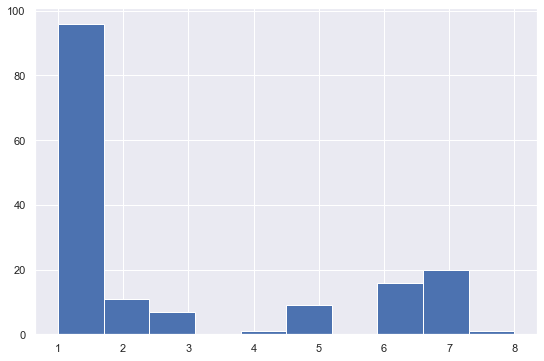

In [72]:
pz['pz_type'].hist()

Как видно из гистограммы наблюдается сильный дисбаланс классов, поэтому классы которые относятся к схожим литотипам можнообъеденить. 

In [73]:
all_fetures_red = pd.read_csv('all_features_red.csv', index_col=0)
all_fetures_red = all_fetures_red.rename(columns={'Komplex_K-means': 'Komplex_K_means'})
xy_coord = pd.read_csv('xy_coord.csv', index_col= 0, sep = '\t')

In [74]:
all_fetures_red.head()

,GR_chehol_layer,GR_Fund_full_grad1000,GR_Fund_near,GR_near_Geoseis,Grav_disp,Grav_os,Komlex_Petrov,Komplex_corr,Komplex_K_means,Komplex_komp,Magn_disp,Magn_os,MP_blizh_Geoseis,MP_Geoseis_full_grad,OST_GR_Filter_Gauss,OST_MP_Filter_Gauss_near,OST_MP_Up_1km_near_smooth,OST_GR_Up_1km_near,OST_GR_Up_1km_near_smooth
0,-0.53,0.18,-9.84,-10.37,0.25,2.77,8.0,0.53,5.0,2.91,1123.94,18.73,193.88,17.39,0.48,36.87,51.82,0.59,0.31
1,-0.53,0.19,-9.86,-10.38,0.25,2.77,8.0,0.52,5.0,2.91,1084.26,18.62,193.00,18.20,0.48,36.89,50.91,0.58,0.29
2,-0.52,0.20,-9.87,-10.40,0.25,2.78,8.0,0.51,5.0,2.91,1049.27,18.61,191.99,19.00,0.47,36.89,49.89,0.58,0.28
3,-0.54,0.15,-9.78,-10.32,0.26,2.75,8.0,0.53,5.0,2.88,1266.40,19.16,194.57,15.61,0.48,36.63,52.61,0.59,0.35
4,-0.53,0.16,-9.80,-10.33,0.26,2.76,8.0,0.53,5.0,2.88,1220.77,18.80,193.96,16.35,0.48,36.69,51.95,0.59,0.34


<AxesSubplot:>

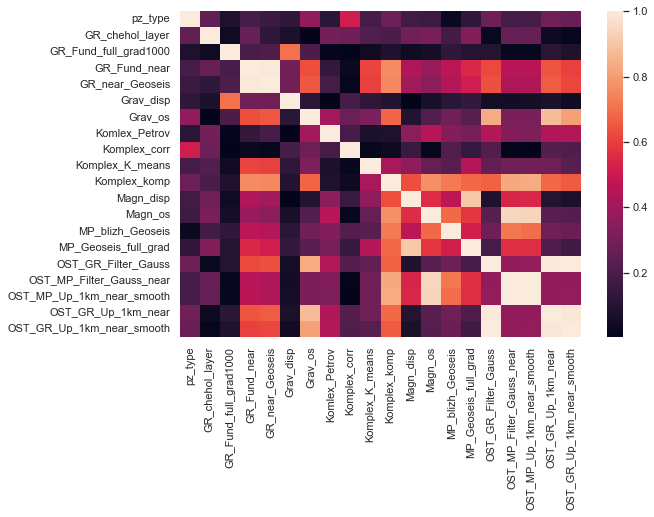

In [75]:
sns.heatmap(abs(pz.corr()))

In [76]:
pz = pz.loc[(pz.pz_type != 4) & (pz.pz_type != 8)]
pz['pz_type'] = pz['pz_type'].replace([2,5,3],4) # combine types with similar litology and properties.

### Paleozoic lithotypes after combining

1 - limestone <b>(reservoir)</b> <br>
4 - all effusives and igneous(non reservoir) <br>
6 - siliceous rock <b>(reservoir)</b> <br>
7 - siliceous limestones <b>(reservoir)</b><br>

<AxesSubplot:xlabel='GR_chehol_layer', ylabel='Count'>

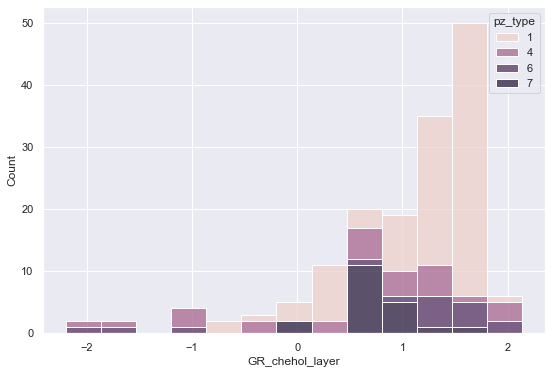

In [77]:
sns.histplot(data=pz, x="GR_chehol_layer", hue="pz_type", multiple="stack")

<AxesSubplot:>

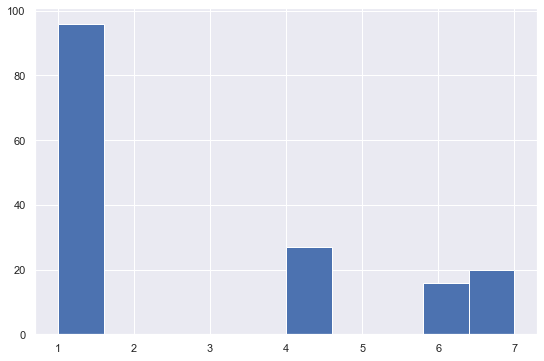

In [78]:
pz['pz_type'].hist()

In [79]:
X = pz.drop('pz_type', axis=1)
Y = pz.pz_type

In [80]:
X_train,x_test,Y_train,y_test = train_test_split(X,Y, test_size=0.33, random_state=0, stratify=Y)

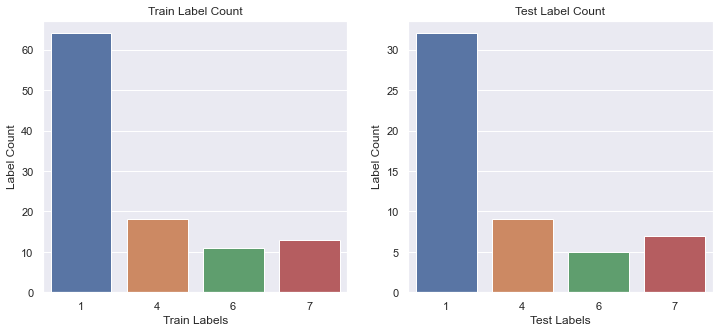

In [81]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
for idx, group in enumerate([('Train', Y_train), ('Test', y_test)]):
    data = group[1].value_counts()
    sns.barplot(ax=ax[idx], x=data.index, y=data.values)
    ax[idx].set_title(f'{group[0]} Label Count')
    ax[idx].set_xlabel(f'{group[0]} Labels')
    ax[idx].set_ylabel('Label Count')

plt.show()

Для начала попробуем единичные алгоритмы, это будет Baseline Solution.

### Random Forest

In [163]:
rf = RandomForestClassifier(random_state=0)

In [164]:
params = {'n_estimators': range(5,50,5),
          'max_depth': range(1,12,2),
          'min_samples_leaf': range(1,7),
          'min_samples_split': range(2,9,2)}

In [165]:
best_rf = RandomizedSearchCV(rf,params, n_jobs=-1, cv=2, scoring= 'precision_macro')

In [166]:
best_rf.fit(X_train,Y_train)

RandomizedSearchCV(cv=2, estimator=RandomForestClassifier(random_state=0),
                   n_jobs=-1,
                   param_distributions={'max_depth': range(1, 12, 2),
                                        'min_samples_leaf': range(1, 7),
                                        'min_samples_split': range(2, 9, 2),
                                        'n_estimators': range(5, 50, 5)},
                   scoring='precision_macro')

In [167]:
best_rf.best_params_

{'n_estimators': 15,
 'min_samples_split': 8,
 'min_samples_leaf': 6,
 'max_depth': 3}

In [168]:
best_par = best_rf.best_estimator_

In [169]:
best_rf = best_par.fit(X_train,Y_train)

In [170]:
y_pred = best_rf.predict(x_test)

In [171]:
y_true = y_test.to_frame(name='class')

In [172]:
conf = pd.DataFrame(confusion_matrix(y_true,y_pred))

<AxesSubplot:>

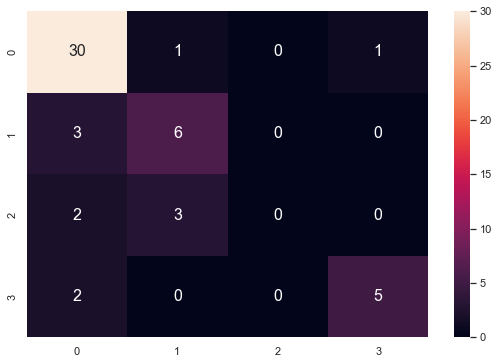

In [173]:
sns.heatmap(conf, annot=True,annot_kws={"size": 16})

In [175]:
rf_p_w = precision_score(y_test,y_pred, average='weighted')
rf_p_m = precision_score(y_test,y_pred, average='macro')
print(rf_p_w,'\n',rf_p_m)

0.7014958354580996 
 0.561036036036036


In [235]:
recall_score(y_test,y_pred, average='weighted')

0.7735849056603774

In [83]:
accuracy_score(y_test, y_pred,)

0.7735849056603774

In [330]:
rf_f1_w = f1_score(y_test, y_pred, average='weighted')
rf_f1_m = f1_score(y_test, y_pred, average='macro')
print(rf_f1_w,rf_f1_m)

0.7091718475835626 0.5337256027554534


### Logistic Regression

In [178]:
log_clf = LogisticRegression()

In [179]:
params = {'penalty' :['l1', 'l2', 'elasticnet'],
          'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'),
          'max_iter': range(1,5000,100),
          'C': np.logspace(-4,4,20)}

In [180]:
log_finder = RandomizedSearchCV(log_clf, params, n_jobs=-1, cv=2, scoring= 'f1_weighted')

In [181]:
log_finder.fit(X_train,Y_train)

RandomizedSearchCV(cv=2, estimator=LogisticRegression(), n_jobs=-1,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'max_iter': range(1, 5000, 100),
                                        'penalty': ['l1', 'l2', 'elasticnet'],
                                        'solver': ('newton-cg', 'lbfgs',
                                                   'liblinear', 'sag',
                                                   'saga')},
                   scoring='f1_weighted')

In [182]:
log_finder.best_params_

{'solver': 'newton-cg',
 'penalty': 'l2',
 'max_iter': 3701,
 'C': 206.913808111479}

In [183]:
log_best = log_finder.best_estimator_

In [184]:
log_best.fit(X_train,Y_train)

LogisticRegression(C=206.913808111479, max_iter=3701, solver='newton-cg')

In [185]:
y_log_pred = log_best.predict(x_test)

In [186]:
log_p_w = precision_score(y_test,y_log_pred, average='weighted')
log_p_m = precision_score(y_test,y_log_pred, average='macro')
print(log_p_w,log_p_m)

0.7764759586122947 0.6521953405017921


In [187]:
log_f1_w = f1_score(y_test, y_log_pred, average='weighted')
log_f1_m = f1_score(y_test, y_log_pred, average='macro')
print(log_f1_w,log_f1_m)

0.7744234800838574 0.6611111111111111


### Cat Boost

In [189]:
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.metrics import accuracy_score
import timeit

In [190]:
test_pool = Pool(x_test,y_test)

In [191]:
  model = CatBoostClassifier(
    iterations=4000,
    learning_rate=0.01,
    objective='MultiClassOneVsAll',
  )
  
  model.fit(
      X_train, Y_train,
      eval_set=(x_test, y_test),
      verbose=10000,
      plot = True
  );  

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6909374	test: 0.6913836	best: 0.6913836 (0)	total: 4.28ms	remaining: 17.1s
3999:	learn: 0.0313148	test: 0.2307341	best: 0.2282672 (2935)	total: 8.73s	remaining: 0us

bestTest = 0.2282671933
bestIteration = 2935

Shrink model to first 2936 iterations.


In [192]:
preds_cat = model.predict(x_test, prediction_type='Class')

In [193]:
eval_metrics = model.eval_metrics(test_pool,[metrics.Precision()], plot= True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [194]:
cat_p_w = precision_score(y_test,preds_cat.reshape(53), average='weighted')
cat_p_m = precision_score(y_test,preds_cat.reshape(53), average='macro')
print(cat_p_w,cat_p_m)

0.741032552353307 0.5989010989010989


In [195]:
preds_cat = preds_cat.reshape(53)

In [196]:
cat_f1_w = f1_score(y_test,preds_cat, average='weighted')
cat_f1_m = f1_score(y_test,preds_cat, average='macro')
print(cat_f1_w,cat_f1_m)

0.7588174052550285 0.5913048394391678


### LGBM

In [197]:
def LGB_CV(learning_rate,num_leaves,n_estimators,
           subsample_freq,min_child_weight       
         ):
    
    param = {
            'num_leaves':int(num_leaves),
            'learning_rate': learning_rate,
            'n_estimators': int(n_estimators), 
            'subsample': 0.8,
            "subsample_freq": int(subsample_freq),
            "colsample_bytree": 0.2,
            'feature_fraction_seed' : 8,
            "min_child_weight" : min_child_weight,
            "n_jobs": -1,
            'random_state':42}
    
    lightgbm = LGBMClassifier(**param)
    best_par_lgbm = lightgbm.fit(X_train,Y_train)
    y_pred_lgbm = best_par_lgbm.predict(x_test)
    F1 = f1_score(y_test,y_pred_lgbm, average='weighted')
    Prec = precision_score(y_test,y_pred_lgbm, average='weighted')
    
    return (F1+Prec)/2

In [198]:
LGB_BO = BayesianOptimization(LGB_CV, {
            'learning_rate': (0.05,0.3),
            'n_estimators': (5000,20000), 
            "subsample_freq": (2,25),
            'min_child_weight': (0.001, 0.7),
            "num_leaves" : (3,25)})

In [20]:
LGB_BO.maximize(
    init_points = 100,
    n_iter = 100
)
print(LGB_BO.max)

|   iter    |  target   | learni... | min_ch... | n_esti... | num_le... | subsam... |
-------------------------------------------------------------------------------------
|  1        |  0.798    |  0.06826  |  0.6982   |  5.556e+0 |  8.19     |  15.44    |
|  2        |  0.811    |  0.1027   |  0.08926  |  7.635e+0 |  4.503    |  10.78    |
|  3        |  0.7929   |  0.2233   |  0.518    |  1.802e+0 |  14.02    |  15.86    |
|  4        |  0.7722   |  0.1825   |  0.4368   |  1.47e+04 |  13.9     |  8.872    |
|  5        |  0.7915   |  0.2432   |  0.5445   |  9.664e+0 |  20.84    |  9.009    |
|  6        |  0.8129   |  0.2348   |  0.3295   |  1.125e+0 |  14.83    |  19.65    |
|  7        |  0.7559   |  0.2049   |  0.1035   |  1.54e+04 |  19.32    |  15.46    |
|  8        |  0.7866   |  0.07948  |  0.5077   |  1.09e+04 |  9.729    |  18.6     |
|  9        |  0.8098   |  0.0854   |  0.2605   |  5.595e+0 |  16.3     |  11.74    |
|  10       |  0.7909   |  0.1826   |  0.04824  |  1.1

|  58       |  0.7966   |  0.1002   |  0.3029   |  1.861e+0 |  17.11    |  13.54    |
|  59       |  0.7711   |  0.2585   |  0.06029  |  1.995e+0 |  24.52    |  7.68     |
|  60       |  0.8129   |  0.09866  |  0.119    |  8.898e+0 |  21.33    |  8.805    |
|  61       |  0.8505   |  0.08894  |  0.617    |  1.923e+0 |  14.44    |  4.604    |
|  62       |  0.7753   |  0.2395   |  0.6551   |  1.953e+0 |  11.09    |  13.74    |
|  63       |  0.8058   |  0.2199   |  0.255    |  6.192e+0 |  5.231    |  8.456    |
|  64       |  0.7724   |  0.2652   |  0.3096   |  1.721e+0 |  16.78    |  24.13    |
|  65       |  0.8388   |  0.1951   |  0.03266  |  1.556e+0 |  6.703    |  21.13    |
|  66       |  0.7753   |  0.2279   |  0.1188   |  9.07e+03 |  16.47    |  10.93    |
|  67       |  0.8447   |  0.1727   |  0.133    |  1.17e+04 |  21.4     |  13.09    |
|  68       |  0.7817   |  0.2492   |  0.1989   |  5.067e+0 |  18.19    |  3.357    |
|  69       |  0.8098   |  0.1655   |  0.6748   |  5.1

|  116      |  0.744    |  0.2769   |  0.5848   |  1.456e+0 |  12.32    |  20.22    |
|  117      |  0.7915   |  0.2409   |  0.02058  |  1.702e+0 |  10.92    |  8.586    |
|  118      |  0.8129   |  0.06286  |  0.3663   |  1.25e+04 |  12.17    |  22.08    |
|  119      |  0.8505   |  0.1441   |  0.1332   |  7.846e+0 |  11.13    |  7.351    |
|  120      |  0.8189   |  0.08465  |  0.1766   |  7.849e+0 |  11.26    |  8.448    |
|  121      |  0.8062   |  0.2812   |  0.08453  |  1.17e+04 |  19.7     |  11.84    |
|  122      |  0.7955   |  0.2704   |  0.3787   |  1.25e+04 |  14.5     |  21.95    |
|  123      |  0.7915   |  0.1472   |  0.5685   |  1.969e+0 |  22.36    |  17.39    |
|  124      |  0.8322   |  0.115    |  0.2567   |  1.941e+0 |  14.17    |  7.691    |
|  125      |  0.7778   |  0.2177   |  0.3182   |  1.171e+0 |  19.61    |  12.99    |
|  126      |  0.8078   |  0.2179   |  0.09324  |  1.941e+0 |  15.11    |  6.473    |
|  127      |  0.8447   |  0.2637   |  0.175    |  1.4

|  174      |  0.7966   |  0.1469   |  0.1114   |  1.508e+0 |  13.2     |  12.31    |
|  175      |  0.7955   |  0.09078  |  0.483    |  1.775e+0 |  12.82    |  22.07    |
|  176      |  0.7866   |  0.1792   |  0.2414   |  1.762e+0 |  19.57    |  13.57    |
|  177      |  0.7966   |  0.05501  |  0.2172   |  1.326e+0 |  13.52    |  9.215    |
|  178      |  0.7753   |  0.2091   |  0.3526   |  1.22e+04 |  8.63     |  5.931    |
|  179      |  0.8202   |  0.1977   |  0.1935   |  1.333e+0 |  21.98    |  21.86    |
|  180      |  0.7955   |  0.1339   |  0.3582   |  1.661e+0 |  24.98    |  2.924    |
|  181      |  0.7884   |  0.1283   |  0.1641   |  1.686e+0 |  4.551    |  22.11    |
|  182      |  0.8117   |  0.2553   |  0.5641   |  9.539e+0 |  17.1     |  6.283    |
|  183      |  0.7722   |  0.1871   |  0.09852  |  1.975e+0 |  12.27    |  8.472    |
|  184      |  0.8129   |  0.1298   |  0.01322  |  6.357e+0 |  21.13    |  21.3     |
|  185      |  0.7837   |  0.1232   |  0.1934   |  8.9

In [112]:
F1

0.7833679400537481

In [199]:
lightgbm = LGBMClassifier()
best_par_lgbm = lightgbm.fit(X_train,Y_train)
y_pred_lgbm = best_par_lgbm.predict(x_test)
#ROC = roc_auc_score(y_test,y_pred_lgbm, average='weighted')
F1 = f1_score(y_test,y_pred_lgbm, average='weighted')


In [200]:
lgbm_p_w = precision_score(y_test,y_pred_lgbm, average='weighted')
lgbm_p_m = precision_score(y_test,y_pred_lgbm, average='macro')
print(lgbm_p_w,lgbm_p_m)

0.799611627974379 0.7019969278033794


### XGBOOST

In [201]:
# в данной модели не тюнил гиперпараметры из за времени рассчета
def XGB_CV(max_depth, gamma, reg_alpha,reg_lambda, colsample_bytree,
             min_child_weight, n_estimators      
         ):
    
    param = {'max_depth':int(max_depth),
             'gamma':(gamma),
             'reg_alpha':int(reg_alpha),
             'reg_lambda':(reg_lambda),
             'colsample_bytree':(colsample_bytree),
             'min_child_weight':int(min_child_weight),
             'n_estimators':int(n_estimators),
             'eta':0.01
             }
    
    xxgbm = XGBClassifier(**param, verbosity = 0)
    best_par_xgbm = xxgbm.fit(X_train,Y_train)
    y_pred_xgbm = best_par_xgbm.predict(x_test)
    F1 = f1_score(y_test,y_pred_xgbm, average='weighted')
    Prec = precision_score(y_test,y_pred_xgbm, average='weighted')
    
    return (F1+Prec)/2

In [202]:
XGB_BO = BayesianOptimization(XGB_CV, {
            'max_depth':(3,20),
             'gamma':(0,1),
             'reg_alpha':(0,0.4),
             'reg_lambda':(0,10),
             'colsample_bytree':(0,1),
             'min_child_weight':(0,10),
             'n_estimators':(100,5000)})

In [63]:
XGB_BO.maximize(
    init_points=30,
    n_iter=100
)
print(XGB_BO.max)

|   iter    |  target   | colsam... |   gamma   | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.8021   |  0.9376   |  0.2696   |  17.85    |  1.193    |  3.837e+0 |  0.2683   |  0.5469   |
|  2        |  0.781    |  0.8989   |  0.2476   |  9.536    |  4.482    |  2.676e+0 |  0.08745  |  9.743    |
|  3        |  0.7233   |  0.916    |  0.6837   |  6.436    |  0.3454   |  618.5    |  0.3979   |  3.214    |
|  4        |  0.721    |  0.1395   |  0.7383   |  17.15    |  4.419    |  1.766e+0 |  0.2632   |  8.361    |
|  5        |  0.721    |  0.4809   |  0.7898   |  7.873    |  8.8      |  4.829e+0 |  0.3475   |  1.897    |
|  6        |  0.7411   |  0.5239   |  0.5598   |  19.19    |  1.946    |  3.567e+0 |  0.1968   |  0.3938   |
|  7        |  0.721    |  0.8711   |  0.2868   |  5.279    |  6.472    |  3.456e+0 |  0.3029   |  6.912    |
|  8      

|  45       |  0.721    |  0.7289   |  0.9278   |  13.92    |  3.684    |  1.127e+0 |  0.2775   |  3.732    |
|  46       |  0.7083   |  0.1047   |  0.98     |  8.652    |  8.342    |  3.329e+0 |  0.2361   |  5.488    |
|  47       |  0.721    |  0.1459   |  0.9779   |  18.04    |  4.304    |  1.124e+0 |  0.3809   |  2.5      |
|  48       |  0.7322   |  0.8675   |  0.3722   |  4.226    |  8.551    |  2.918e+0 |  0.2932   |  3.159    |
|  49       |  0.721    |  0.2542   |  0.6085   |  15.68    |  3.073    |  4.565e+0 |  0.1212   |  5.071    |
|  50       |  0.8157   |  0.4051   |  0.3677   |  16.28    |  2.276    |  3.836e+0 |  0.3573   |  1.238    |
|  51       |  0.721    |  0.5276   |  0.8738   |  17.12    |  1.403    |  3.836e+0 |  0.09829  |  2.798    |
|  52       |  0.7528   |  0.2876   |  0.1214   |  5.706    |  5.39     |  2.916e+0 |  0.2861   |  2.678    |
|  53       |  0.721    |  0.1739   |  0.2161   |  9.021    |  3.006    |  2.676e+0 |  0.2835   |  9.767    |
|  54     

|  90       |  0.721    |  0.9949   |  0.4399   |  13.8     |  3.282    |  4.568e+0 |  0.181    |  8.091    |
|  91       |  0.721    |  0.8239   |  0.7218   |  16.2     |  1.456    |  1.127e+0 |  0.3725   |  5.797    |
|  92       |  0.8358   |  0.3967   |  0.1392   |  11.27    |  4.788    |  4.601e+0 |  0.06744  |  0.9819   |
|  93       |  0.721    |  0.6598   |  0.9929   |  4.721    |  5.074    |  893.6    |  0.2682   |  4.234    |
|  94       |  0.73     |  0.1109   |  0.3213   |  9.184    |  8.849    |  1.116e+0 |  0.3679   |  9.033    |
|  95       |  0.721    |  0.6045   |  0.2687   |  19.39    |  5.042    |  304.9    |  0.3941   |  6.096    |
|  96       |  0.7114   |  0.06647  |  0.03157  |  15.66    |  8.179    |  784.9    |  0.3907   |  4.655    |
|  97       |  0.721    |  0.6345   |  0.8434   |  16.91    |  1.342    |  1.125e+0 |  0.01705  |  2.801    |
|  98       |  0.721    |  0.9692   |  0.9078   |  5.507    |  4.784    |  2.916e+0 |  0.08925  |  1.969    |
|  99     

In [204]:
xgbm = XGBClassifier()
best_par_xgbm = xgbm.fit(X_train,Y_train)
y_pred_xgbm = best_par_xgbm.predict(x_test)

In [205]:
xgb_p_w = precision_score(y_test,y_pred_xgbm, average='weighted')
xgb_p_m = precision_score(y_test,y_pred_xgbm, average='macro')
print(xgb_p_w,xgb_p_m)

0.8051743853630647 0.7064393939393939


### AdaBoost

In [158]:
abc = AdaBoostClassifier(learning_rate=0.9, n_estimators = 45)

In [159]:
abc_fit = abc.fit(X_train,Y_train)
y_pred_ada = abc_fit.predict(x_test)

In [160]:
ada_p_w = precision_score(y_test,y_pred_ada, average='weighted')
ada_p_m = precision_score(y_test,y_pred_ada, average='macro')
print(ada_p_w,ada_p_m)

0.7418388739143456 0.654265873015873


### KNN

In [206]:
params = {'knn__n_neighbors': range(2,20,2),
          'knn__leaf_size': range(2,20,2)}

In [207]:
scaler = StandardScaler()

In [208]:
knn = KNeighborsClassifier()

In [209]:
pipe_knn = Pipeline(steps = [('scaler',scaler), 
                   ('knn',knn)])                                 

In [210]:
grid_par = GridSearchCV(pipe_knn,params)

In [211]:
search_knn = grid_par.fit(X_train, Y_train)

In [212]:
search_knn.best_params_

{'knn__leaf_size': 2, 'knn__n_neighbors': 2}

In [213]:
best_knn = search_knn.best_estimator_

In [214]:
best_knn_model = best_knn.fit(X_train, Y_train)

In [215]:
knn_y_pred = best_knn_model.predict(x_test)

In [216]:
knn_p_w = precision_score(y_test,knn_y_pred, average='weighted')
knn_p_m = precision_score(y_test,knn_y_pred, average='macro')
print(knn_p_w,knn_p_m)

0.7212264150943396 0.60625


### SVM RBF

In [217]:
clf_svc = make_pipeline(StandardScaler(),SGDClassifier())

In [218]:
svc_model = clf_svc.fit(X_train, Y_train)

In [219]:
y_pred_svm = svc_model.predict(x_test)

In [220]:
svm_p_w = precision_score(y_test,y_pred_svm, average='weighted')
svm_p_m = precision_score(y_test,y_pred_svm, average='macro')
print(svm_p_w,svm_p_m)

0.7229845626072041 0.599025974025974


In [221]:
recall_score(y_test,y_pred_svm, average='weighted')

0.7358490566037735

In [222]:
accuracy_score(y_test, y_pred_svm,)

0.7358490566037735

In [223]:
f1_score(y_test, y_pred_svm, average='weighted')

0.7274730731036589

## Stack Models

### Stacking Classifier

In [240]:
estimators = [
    ('rf', RandomForestClassifier(max_depth = 5,
                                  min_samples_leaf = 1,
                                  min_samples_split = 4,
                                  n_estimators = 30,
                                  random_state=42)),
    ('cat', CatBoostClassifier(iterations=2500,
    learning_rate=0.01,
    objective='MultiClassOneVsAll')),
    ('lgbm', LGBMClassifier(random_state=42)),
    ('xgbm', XGBClassifier(random_state=42)),
    ('knn', KNeighborsClassifier(leaf_size=2,
                                 n_neighbors = 6)),
    ("ada", AdaBoostClassifier(learning_rate=0.9, n_estimators = 45))]

In [241]:
sclf = StackingClassifier(cv= 2,
    estimators=estimators)

In [242]:
sclf.fit(X_train, Y_train).score(x_test, y_test)

0:	learn: 0.6909374	total: 2.4ms	remaining: 6s
1:	learn: 0.6880512	total: 5.54ms	remaining: 6.92s
2:	learn: 0.6851110	total: 7.64ms	remaining: 6.36s
3:	learn: 0.6828434	total: 9.56ms	remaining: 5.97s
4:	learn: 0.6803611	total: 11.6ms	remaining: 5.79s
5:	learn: 0.6774829	total: 13.4ms	remaining: 5.57s
6:	learn: 0.6750075	total: 15.1ms	remaining: 5.38s
7:	learn: 0.6719015	total: 16.9ms	remaining: 5.26s
8:	learn: 0.6697702	total: 19.1ms	remaining: 5.29s
9:	learn: 0.6665850	total: 21.1ms	remaining: 5.26s
10:	learn: 0.6640421	total: 23ms	remaining: 5.2s
11:	learn: 0.6612700	total: 25.3ms	remaining: 5.25s
12:	learn: 0.6587304	total: 27.2ms	remaining: 5.2s
13:	learn: 0.6563344	total: 29.1ms	remaining: 5.17s
14:	learn: 0.6531332	total: 30.9ms	remaining: 5.12s
15:	learn: 0.6501947	total: 32.9ms	remaining: 5.1s
16:	learn: 0.6480161	total: 35ms	remaining: 5.11s
17:	learn: 0.6455898	total: 36.7ms	remaining: 5.06s
18:	learn: 0.6435706	total: 38.5ms	remaining: 5.03s
19:	learn: 0.6412487	total: 40.3m

189:	learn: 0.3916467	total: 351ms	remaining: 4.27s
190:	learn: 0.3908664	total: 354ms	remaining: 4.28s
191:	learn: 0.3901209	total: 356ms	remaining: 4.28s
192:	learn: 0.3892509	total: 358ms	remaining: 4.28s
193:	learn: 0.3881708	total: 361ms	remaining: 4.29s
194:	learn: 0.3872183	total: 363ms	remaining: 4.29s
195:	learn: 0.3865927	total: 365ms	remaining: 4.29s
196:	learn: 0.3856178	total: 367ms	remaining: 4.29s
197:	learn: 0.3847993	total: 369ms	remaining: 4.29s
198:	learn: 0.3841078	total: 372ms	remaining: 4.3s
199:	learn: 0.3833651	total: 374ms	remaining: 4.3s
200:	learn: 0.3824355	total: 376ms	remaining: 4.3s
201:	learn: 0.3816075	total: 378ms	remaining: 4.3s
202:	learn: 0.3806175	total: 381ms	remaining: 4.31s
203:	learn: 0.3798987	total: 383ms	remaining: 4.31s
204:	learn: 0.3790897	total: 385ms	remaining: 4.31s
205:	learn: 0.3783356	total: 387ms	remaining: 4.31s
206:	learn: 0.3775318	total: 389ms	remaining: 4.31s
207:	learn: 0.3768855	total: 391ms	remaining: 4.31s
208:	learn: 0.37

381:	learn: 0.2773529	total: 711ms	remaining: 3.94s
382:	learn: 0.2770062	total: 714ms	remaining: 3.94s
383:	learn: 0.2766523	total: 716ms	remaining: 3.94s
384:	learn: 0.2762392	total: 718ms	remaining: 3.94s
385:	learn: 0.2758881	total: 720ms	remaining: 3.94s
386:	learn: 0.2754455	total: 723ms	remaining: 3.94s
387:	learn: 0.2750777	total: 725ms	remaining: 3.94s
388:	learn: 0.2747083	total: 726ms	remaining: 3.94s
389:	learn: 0.2741765	total: 728ms	remaining: 3.94s
390:	learn: 0.2737892	total: 730ms	remaining: 3.94s
391:	learn: 0.2734293	total: 731ms	remaining: 3.93s
392:	learn: 0.2731150	total: 733ms	remaining: 3.93s
393:	learn: 0.2727302	total: 735ms	remaining: 3.93s
394:	learn: 0.2723798	total: 737ms	remaining: 3.93s
395:	learn: 0.2720325	total: 739ms	remaining: 3.93s
396:	learn: 0.2716964	total: 741ms	remaining: 3.92s
397:	learn: 0.2713540	total: 743ms	remaining: 3.92s
398:	learn: 0.2708825	total: 745ms	remaining: 3.92s
399:	learn: 0.2704990	total: 746ms	remaining: 3.92s
400:	learn: 

576:	learn: 0.2128763	total: 1.07s	remaining: 3.57s
577:	learn: 0.2125654	total: 1.07s	remaining: 3.57s
578:	learn: 0.2122876	total: 1.07s	remaining: 3.57s
579:	learn: 0.2120773	total: 1.08s	remaining: 3.57s
580:	learn: 0.2117693	total: 1.08s	remaining: 3.56s
581:	learn: 0.2115330	total: 1.08s	remaining: 3.56s
582:	learn: 0.2112045	total: 1.08s	remaining: 3.56s
583:	learn: 0.2109110	total: 1.08s	remaining: 3.56s
584:	learn: 0.2106935	total: 1.09s	remaining: 3.56s
585:	learn: 0.2104397	total: 1.09s	remaining: 3.56s
586:	learn: 0.2102194	total: 1.09s	remaining: 3.56s
587:	learn: 0.2099980	total: 1.09s	remaining: 3.55s
588:	learn: 0.2097563	total: 1.09s	remaining: 3.55s
589:	learn: 0.2094502	total: 1.1s	remaining: 3.55s
590:	learn: 0.2091653	total: 1.1s	remaining: 3.55s
591:	learn: 0.2089766	total: 1.1s	remaining: 3.54s
592:	learn: 0.2086551	total: 1.1s	remaining: 3.54s
593:	learn: 0.2084160	total: 1.1s	remaining: 3.54s
594:	learn: 0.2081668	total: 1.1s	remaining: 3.54s
595:	learn: 0.2079

770:	learn: 0.1672332	total: 1.43s	remaining: 3.21s
771:	learn: 0.1669895	total: 1.43s	remaining: 3.21s
772:	learn: 0.1667795	total: 1.43s	remaining: 3.2s
773:	learn: 0.1665219	total: 1.44s	remaining: 3.2s
774:	learn: 0.1662840	total: 1.44s	remaining: 3.2s
775:	learn: 0.1660985	total: 1.44s	remaining: 3.2s
776:	learn: 0.1658850	total: 1.44s	remaining: 3.2s
777:	learn: 0.1656372	total: 1.44s	remaining: 3.2s
778:	learn: 0.1654349	total: 1.45s	remaining: 3.2s
779:	learn: 0.1651851	total: 1.45s	remaining: 3.19s
780:	learn: 0.1649993	total: 1.45s	remaining: 3.19s
781:	learn: 0.1648427	total: 1.45s	remaining: 3.19s
782:	learn: 0.1646811	total: 1.45s	remaining: 3.19s
783:	learn: 0.1645433	total: 1.46s	remaining: 3.19s
784:	learn: 0.1643357	total: 1.46s	remaining: 3.19s
785:	learn: 0.1641456	total: 1.46s	remaining: 3.18s
786:	learn: 0.1639125	total: 1.46s	remaining: 3.18s
787:	learn: 0.1637281	total: 1.46s	remaining: 3.18s
788:	learn: 0.1635136	total: 1.47s	remaining: 3.18s
789:	learn: 0.16332

959:	learn: 0.1353347	total: 1.79s	remaining: 2.87s
960:	learn: 0.1351893	total: 1.79s	remaining: 2.87s
961:	learn: 0.1350824	total: 1.79s	remaining: 2.87s
962:	learn: 0.1349821	total: 1.8s	remaining: 2.87s
963:	learn: 0.1348621	total: 1.8s	remaining: 2.87s
964:	learn: 0.1347042	total: 1.8s	remaining: 2.87s
965:	learn: 0.1345969	total: 1.8s	remaining: 2.86s
966:	learn: 0.1344659	total: 1.8s	remaining: 2.86s
967:	learn: 0.1343395	total: 1.81s	remaining: 2.86s
968:	learn: 0.1341921	total: 1.81s	remaining: 2.86s
969:	learn: 0.1340612	total: 1.82s	remaining: 2.88s
970:	learn: 0.1339482	total: 1.82s	remaining: 2.87s
971:	learn: 0.1338082	total: 1.83s	remaining: 2.87s
972:	learn: 0.1336935	total: 1.83s	remaining: 2.87s
973:	learn: 0.1335837	total: 1.83s	remaining: 2.87s
974:	learn: 0.1334856	total: 1.83s	remaining: 2.87s
975:	learn: 0.1333685	total: 1.83s	remaining: 2.87s
976:	learn: 0.1332309	total: 1.84s	remaining: 2.86s
977:	learn: 0.1331102	total: 1.84s	remaining: 2.86s
978:	learn: 0.132

1145:	learn: 0.1143594	total: 2.15s	remaining: 2.54s
1146:	learn: 0.1142748	total: 2.15s	remaining: 2.54s
1147:	learn: 0.1141885	total: 2.15s	remaining: 2.54s
1148:	learn: 0.1140842	total: 2.16s	remaining: 2.54s
1149:	learn: 0.1139656	total: 2.16s	remaining: 2.53s
1150:	learn: 0.1138826	total: 2.16s	remaining: 2.53s
1151:	learn: 0.1138197	total: 2.16s	remaining: 2.53s
1152:	learn: 0.1137169	total: 2.16s	remaining: 2.53s
1153:	learn: 0.1136076	total: 2.17s	remaining: 2.53s
1154:	learn: 0.1135035	total: 2.17s	remaining: 2.53s
1155:	learn: 0.1134273	total: 2.17s	remaining: 2.52s
1156:	learn: 0.1133257	total: 2.17s	remaining: 2.52s
1157:	learn: 0.1132052	total: 2.17s	remaining: 2.52s
1158:	learn: 0.1131164	total: 2.18s	remaining: 2.52s
1159:	learn: 0.1130077	total: 2.18s	remaining: 2.52s
1160:	learn: 0.1128920	total: 2.18s	remaining: 2.52s
1161:	learn: 0.1128043	total: 2.18s	remaining: 2.52s
1162:	learn: 0.1126966	total: 2.19s	remaining: 2.51s
1163:	learn: 0.1126238	total: 2.19s	remaining:

1330:	learn: 0.0986705	total: 2.51s	remaining: 2.2s
1331:	learn: 0.0986150	total: 2.51s	remaining: 2.2s
1332:	learn: 0.0985437	total: 2.51s	remaining: 2.2s
1333:	learn: 0.0984876	total: 2.52s	remaining: 2.2s
1334:	learn: 0.0984078	total: 2.52s	remaining: 2.2s
1335:	learn: 0.0983201	total: 2.52s	remaining: 2.2s
1336:	learn: 0.0982563	total: 2.52s	remaining: 2.19s
1337:	learn: 0.0981727	total: 2.52s	remaining: 2.19s
1338:	learn: 0.0981231	total: 2.53s	remaining: 2.19s
1339:	learn: 0.0980502	total: 2.53s	remaining: 2.19s
1340:	learn: 0.0979888	total: 2.53s	remaining: 2.19s
1341:	learn: 0.0979231	total: 2.53s	remaining: 2.18s
1342:	learn: 0.0978195	total: 2.53s	remaining: 2.18s
1343:	learn: 0.0977549	total: 2.53s	remaining: 2.18s
1344:	learn: 0.0976974	total: 2.54s	remaining: 2.18s
1345:	learn: 0.0976150	total: 2.54s	remaining: 2.18s
1346:	learn: 0.0975529	total: 2.54s	remaining: 2.17s
1347:	learn: 0.0974837	total: 2.54s	remaining: 2.17s
1348:	learn: 0.0973981	total: 2.54s	remaining: 2.17s

1529:	learn: 0.0858361	total: 2.87s	remaining: 1.82s
1530:	learn: 0.0857887	total: 2.87s	remaining: 1.82s
1531:	learn: 0.0857462	total: 2.87s	remaining: 1.82s
1532:	learn: 0.0856952	total: 2.88s	remaining: 1.81s
1533:	learn: 0.0856313	total: 2.88s	remaining: 1.81s
1534:	learn: 0.0855785	total: 2.88s	remaining: 1.81s
1535:	learn: 0.0855445	total: 2.88s	remaining: 1.81s
1536:	learn: 0.0854979	total: 2.88s	remaining: 1.81s
1537:	learn: 0.0854425	total: 2.89s	remaining: 1.8s
1538:	learn: 0.0853691	total: 2.89s	remaining: 1.8s
1539:	learn: 0.0852967	total: 2.89s	remaining: 1.8s
1540:	learn: 0.0852362	total: 2.89s	remaining: 1.8s
1541:	learn: 0.0851852	total: 2.89s	remaining: 1.8s
1542:	learn: 0.0851382	total: 2.9s	remaining: 1.79s
1543:	learn: 0.0850617	total: 2.9s	remaining: 1.79s
1544:	learn: 0.0850057	total: 2.9s	remaining: 1.79s
1545:	learn: 0.0849261	total: 2.9s	remaining: 1.79s
1546:	learn: 0.0848471	total: 2.9s	remaining: 1.79s
1547:	learn: 0.0847928	total: 2.9s	remaining: 1.79s
1548

1715:	learn: 0.0767574	total: 3.23s	remaining: 1.48s
1716:	learn: 0.0767264	total: 3.23s	remaining: 1.47s
1717:	learn: 0.0766725	total: 3.23s	remaining: 1.47s
1718:	learn: 0.0766274	total: 3.24s	remaining: 1.47s
1719:	learn: 0.0765815	total: 3.24s	remaining: 1.47s
1720:	learn: 0.0765336	total: 3.24s	remaining: 1.47s
1721:	learn: 0.0764990	total: 3.24s	remaining: 1.47s
1722:	learn: 0.0764602	total: 3.25s	remaining: 1.46s
1723:	learn: 0.0764067	total: 3.25s	remaining: 1.46s
1724:	learn: 0.0763585	total: 3.25s	remaining: 1.46s
1725:	learn: 0.0763314	total: 3.25s	remaining: 1.46s
1726:	learn: 0.0762905	total: 3.25s	remaining: 1.46s
1727:	learn: 0.0762447	total: 3.25s	remaining: 1.45s
1728:	learn: 0.0762215	total: 3.26s	remaining: 1.45s
1729:	learn: 0.0761737	total: 3.26s	remaining: 1.45s
1730:	learn: 0.0761271	total: 3.26s	remaining: 1.45s
1731:	learn: 0.0760808	total: 3.26s	remaining: 1.45s
1732:	learn: 0.0760394	total: 3.26s	remaining: 1.44s
1733:	learn: 0.0759860	total: 3.27s	remaining:

1910:	learn: 0.0690063	total: 3.59s	remaining: 1.11s
1911:	learn: 0.0689575	total: 3.59s	remaining: 1.1s
1912:	learn: 0.0689196	total: 3.59s	remaining: 1.1s
1913:	learn: 0.0688897	total: 3.6s	remaining: 1.1s
1914:	learn: 0.0688358	total: 3.6s	remaining: 1.1s
1915:	learn: 0.0687843	total: 3.6s	remaining: 1.1s
1916:	learn: 0.0687581	total: 3.6s	remaining: 1.09s
1917:	learn: 0.0687210	total: 3.6s	remaining: 1.09s
1918:	learn: 0.0686723	total: 3.61s	remaining: 1.09s
1919:	learn: 0.0686356	total: 3.61s	remaining: 1.09s
1920:	learn: 0.0685918	total: 3.61s	remaining: 1.09s
1921:	learn: 0.0685587	total: 3.61s	remaining: 1.09s
1922:	learn: 0.0685230	total: 3.61s	remaining: 1.08s
1923:	learn: 0.0684934	total: 3.62s	remaining: 1.08s
1924:	learn: 0.0684384	total: 3.63s	remaining: 1.08s
1925:	learn: 0.0683944	total: 3.63s	remaining: 1.08s
1926:	learn: 0.0683667	total: 3.63s	remaining: 1.08s
1927:	learn: 0.0683241	total: 3.63s	remaining: 1.08s
1928:	learn: 0.0682869	total: 3.63s	remaining: 1.07s
192

2095:	learn: 0.0626861	total: 3.95s	remaining: 762ms
2096:	learn: 0.0626549	total: 3.95s	remaining: 760ms
2097:	learn: 0.0626160	total: 3.96s	remaining: 758ms
2098:	learn: 0.0625803	total: 3.96s	remaining: 756ms
2099:	learn: 0.0625540	total: 3.96s	remaining: 754ms
2100:	learn: 0.0625323	total: 3.96s	remaining: 752ms
2101:	learn: 0.0624909	total: 3.96s	remaining: 751ms
2102:	learn: 0.0624535	total: 3.96s	remaining: 749ms
2103:	learn: 0.0624253	total: 3.97s	remaining: 747ms
2104:	learn: 0.0623830	total: 3.97s	remaining: 745ms
2105:	learn: 0.0623629	total: 3.97s	remaining: 743ms
2106:	learn: 0.0623281	total: 3.97s	remaining: 741ms
2107:	learn: 0.0623072	total: 3.98s	remaining: 739ms
2108:	learn: 0.0622746	total: 3.98s	remaining: 737ms
2109:	learn: 0.0622337	total: 3.98s	remaining: 735ms
2110:	learn: 0.0622065	total: 3.98s	remaining: 734ms
2111:	learn: 0.0621726	total: 3.98s	remaining: 732ms
2112:	learn: 0.0621353	total: 3.98s	remaining: 730ms
2113:	learn: 0.0621071	total: 3.99s	remaining:

2283:	learn: 0.0574142	total: 4.31s	remaining: 408ms
2284:	learn: 0.0573775	total: 4.31s	remaining: 406ms
2285:	learn: 0.0573597	total: 4.31s	remaining: 404ms
2286:	learn: 0.0573392	total: 4.32s	remaining: 402ms
2287:	learn: 0.0573100	total: 4.32s	remaining: 400ms
2288:	learn: 0.0572806	total: 4.32s	remaining: 398ms
2289:	learn: 0.0572532	total: 4.32s	remaining: 396ms
2290:	learn: 0.0572204	total: 4.32s	remaining: 395ms
2291:	learn: 0.0571959	total: 4.33s	remaining: 393ms
2292:	learn: 0.0571750	total: 4.33s	remaining: 391ms
2293:	learn: 0.0571529	total: 4.33s	remaining: 389ms
2294:	learn: 0.0571298	total: 4.33s	remaining: 387ms
2295:	learn: 0.0571109	total: 4.33s	remaining: 385ms
2296:	learn: 0.0570826	total: 4.33s	remaining: 383ms
2297:	learn: 0.0570511	total: 4.34s	remaining: 381ms
2298:	learn: 0.0570285	total: 4.34s	remaining: 379ms
2299:	learn: 0.0570136	total: 4.34s	remaining: 377ms
2300:	learn: 0.0569866	total: 4.34s	remaining: 376ms
2301:	learn: 0.0569670	total: 4.34s	remaining:

2481:	learn: 0.0524993	total: 4.67s	remaining: 33.9ms
2482:	learn: 0.0524721	total: 4.67s	remaining: 32ms
2483:	learn: 0.0524460	total: 4.68s	remaining: 30.1ms
2484:	learn: 0.0524107	total: 4.68s	remaining: 28.2ms
2485:	learn: 0.0523858	total: 4.68s	remaining: 26.4ms
2486:	learn: 0.0523563	total: 4.68s	remaining: 24.5ms
2487:	learn: 0.0523403	total: 4.68s	remaining: 22.6ms
2488:	learn: 0.0523177	total: 4.69s	remaining: 20.7ms
2489:	learn: 0.0522932	total: 4.69s	remaining: 18.8ms
2490:	learn: 0.0522612	total: 4.69s	remaining: 16.9ms
2491:	learn: 0.0522460	total: 4.69s	remaining: 15.1ms
2492:	learn: 0.0522170	total: 4.69s	remaining: 13.2ms
2493:	learn: 0.0521941	total: 4.7s	remaining: 11.3ms
2494:	learn: 0.0521714	total: 4.7s	remaining: 9.41ms
2495:	learn: 0.0521574	total: 4.7s	remaining: 7.53ms
2496:	learn: 0.0521380	total: 4.7s	remaining: 5.65ms
2497:	learn: 0.0521173	total: 4.7s	remaining: 3.77ms
2498:	learn: 0.0521044	total: 4.71s	remaining: 1.88ms
2499:	learn: 0.0520882	total: 4.71s

268:	learn: 0.3887343	total: 357ms	remaining: 2.96s
269:	learn: 0.3880445	total: 358ms	remaining: 2.96s
270:	learn: 0.3872651	total: 360ms	remaining: 2.96s
271:	learn: 0.3863806	total: 362ms	remaining: 2.96s
272:	learn: 0.3856696	total: 364ms	remaining: 2.97s
273:	learn: 0.3847405	total: 366ms	remaining: 2.97s
274:	learn: 0.3841869	total: 367ms	remaining: 2.97s
275:	learn: 0.3836210	total: 370ms	remaining: 2.98s
276:	learn: 0.3829849	total: 372ms	remaining: 2.98s
277:	learn: 0.3823165	total: 373ms	remaining: 2.98s
278:	learn: 0.3810786	total: 374ms	remaining: 2.98s
279:	learn: 0.3806157	total: 375ms	remaining: 2.98s
280:	learn: 0.3798335	total: 377ms	remaining: 2.97s
281:	learn: 0.3793479	total: 378ms	remaining: 2.97s
282:	learn: 0.3787131	total: 380ms	remaining: 2.97s
283:	learn: 0.3779821	total: 381ms	remaining: 2.97s
284:	learn: 0.3775658	total: 383ms	remaining: 2.97s
285:	learn: 0.3770773	total: 384ms	remaining: 2.97s
286:	learn: 0.3764484	total: 386ms	remaining: 2.98s
287:	learn: 

462:	learn: 0.2886371	total: 714ms	remaining: 3.14s
463:	learn: 0.2883042	total: 717ms	remaining: 3.14s
464:	learn: 0.2880015	total: 719ms	remaining: 3.15s
465:	learn: 0.2874181	total: 721ms	remaining: 3.15s
466:	learn: 0.2870663	total: 723ms	remaining: 3.15s
467:	learn: 0.2867071	total: 726ms	remaining: 3.15s
468:	learn: 0.2863755	total: 728ms	remaining: 3.15s
469:	learn: 0.2859524	total: 731ms	remaining: 3.16s
470:	learn: 0.2855341	total: 733ms	remaining: 3.16s
471:	learn: 0.2851710	total: 736ms	remaining: 3.16s
472:	learn: 0.2847597	total: 738ms	remaining: 3.16s
473:	learn: 0.2843742	total: 740ms	remaining: 3.16s
474:	learn: 0.2840586	total: 742ms	remaining: 3.16s
475:	learn: 0.2836405	total: 744ms	remaining: 3.16s
476:	learn: 0.2829885	total: 746ms	remaining: 3.17s
477:	learn: 0.2826453	total: 749ms	remaining: 3.17s
478:	learn: 0.2821948	total: 751ms	remaining: 3.17s
479:	learn: 0.2818116	total: 753ms	remaining: 3.17s
480:	learn: 0.2814169	total: 756ms	remaining: 3.17s
481:	learn: 

667:	learn: 0.2142835	total: 1.25s	remaining: 3.42s
668:	learn: 0.2139686	total: 1.25s	remaining: 3.42s
669:	learn: 0.2135694	total: 1.25s	remaining: 3.42s
670:	learn: 0.2132603	total: 1.26s	remaining: 3.43s
671:	learn: 0.2129345	total: 1.26s	remaining: 3.43s
672:	learn: 0.2125342	total: 1.26s	remaining: 3.43s
673:	learn: 0.2121895	total: 1.27s	remaining: 3.43s
674:	learn: 0.2117970	total: 1.27s	remaining: 3.44s
675:	learn: 0.2114847	total: 1.27s	remaining: 3.44s
676:	learn: 0.2112486	total: 1.28s	remaining: 3.44s
677:	learn: 0.2109631	total: 1.28s	remaining: 3.44s
678:	learn: 0.2107669	total: 1.28s	remaining: 3.44s
679:	learn: 0.2104900	total: 1.28s	remaining: 3.44s
680:	learn: 0.2101272	total: 1.29s	remaining: 3.44s
681:	learn: 0.2098961	total: 1.29s	remaining: 3.44s
682:	learn: 0.2096056	total: 1.29s	remaining: 3.44s
683:	learn: 0.2092767	total: 1.3s	remaining: 3.44s
684:	learn: 0.2089446	total: 1.3s	remaining: 3.44s
685:	learn: 0.2085933	total: 1.3s	remaining: 3.45s
686:	learn: 0.2

854:	learn: 0.1658117	total: 1.96s	remaining: 3.77s
855:	learn: 0.1656110	total: 1.96s	remaining: 3.77s
856:	learn: 0.1653698	total: 1.97s	remaining: 3.77s
857:	learn: 0.1650970	total: 1.97s	remaining: 3.77s
858:	learn: 0.1648940	total: 1.97s	remaining: 3.77s
859:	learn: 0.1646836	total: 1.98s	remaining: 3.77s
860:	learn: 0.1645265	total: 1.98s	remaining: 3.77s
861:	learn: 0.1643245	total: 1.99s	remaining: 3.77s
862:	learn: 0.1640500	total: 1.99s	remaining: 3.77s
863:	learn: 0.1638569	total: 1.99s	remaining: 3.77s
864:	learn: 0.1636827	total: 2s	remaining: 3.77s
865:	learn: 0.1634222	total: 2s	remaining: 3.77s
866:	learn: 0.1631885	total: 2s	remaining: 3.77s
867:	learn: 0.1630251	total: 2.01s	remaining: 3.77s
868:	learn: 0.1628710	total: 2.01s	remaining: 3.77s
869:	learn: 0.1627291	total: 2.01s	remaining: 3.77s
870:	learn: 0.1624436	total: 2.02s	remaining: 3.77s
871:	learn: 0.1621694	total: 2.02s	remaining: 3.77s
872:	learn: 0.1620096	total: 2.02s	remaining: 3.77s
873:	learn: 0.1618298

1042:	learn: 0.1333902	total: 2.49s	remaining: 3.48s
1043:	learn: 0.1332601	total: 2.49s	remaining: 3.48s
1044:	learn: 0.1331586	total: 2.5s	remaining: 3.48s
1045:	learn: 0.1330184	total: 2.5s	remaining: 3.47s
1046:	learn: 0.1329224	total: 2.5s	remaining: 3.47s
1047:	learn: 0.1328183	total: 2.5s	remaining: 3.47s
1048:	learn: 0.1326861	total: 2.51s	remaining: 3.47s
1049:	learn: 0.1325544	total: 2.51s	remaining: 3.47s
1050:	learn: 0.1324118	total: 2.51s	remaining: 3.46s
1051:	learn: 0.1322573	total: 2.52s	remaining: 3.46s
1052:	learn: 0.1320887	total: 2.52s	remaining: 3.46s
1053:	learn: 0.1319941	total: 2.52s	remaining: 3.46s
1054:	learn: 0.1318708	total: 2.52s	remaining: 3.46s
1055:	learn: 0.1316874	total: 2.53s	remaining: 3.46s
1056:	learn: 0.1315830	total: 2.53s	remaining: 3.45s
1057:	learn: 0.1314473	total: 2.53s	remaining: 3.45s
1058:	learn: 0.1313216	total: 2.54s	remaining: 3.45s
1059:	learn: 0.1312230	total: 2.54s	remaining: 3.45s
1060:	learn: 0.1310913	total: 2.54s	remaining: 3.4

1258:	learn: 0.1085360	total: 3.02s	remaining: 2.98s
1259:	learn: 0.1084736	total: 3.03s	remaining: 2.98s
1260:	learn: 0.1083710	total: 3.03s	remaining: 2.98s
1261:	learn: 0.1082984	total: 3.03s	remaining: 2.97s
1262:	learn: 0.1081878	total: 3.03s	remaining: 2.97s
1263:	learn: 0.1080942	total: 3.04s	remaining: 2.97s
1264:	learn: 0.1080280	total: 3.04s	remaining: 2.97s
1265:	learn: 0.1079629	total: 3.04s	remaining: 2.96s
1266:	learn: 0.1078675	total: 3.04s	remaining: 2.96s
1267:	learn: 0.1077714	total: 3.05s	remaining: 2.96s
1268:	learn: 0.1076625	total: 3.05s	remaining: 2.96s
1269:	learn: 0.1075800	total: 3.05s	remaining: 2.96s
1270:	learn: 0.1075193	total: 3.05s	remaining: 2.95s
1271:	learn: 0.1073853	total: 3.06s	remaining: 2.95s
1272:	learn: 0.1072677	total: 3.06s	remaining: 2.95s
1273:	learn: 0.1071635	total: 3.06s	remaining: 2.95s
1274:	learn: 0.1070730	total: 3.06s	remaining: 2.94s
1275:	learn: 0.1069632	total: 3.06s	remaining: 2.94s
1276:	learn: 0.1068976	total: 3.07s	remaining:

1460:	learn: 0.0918493	total: 3.56s	remaining: 2.53s
1461:	learn: 0.0917786	total: 3.56s	remaining: 2.53s
1462:	learn: 0.0916730	total: 3.56s	remaining: 2.52s
1463:	learn: 0.0916099	total: 3.56s	remaining: 2.52s
1464:	learn: 0.0915508	total: 3.57s	remaining: 2.52s
1465:	learn: 0.0914558	total: 3.57s	remaining: 2.52s
1466:	learn: 0.0914022	total: 3.58s	remaining: 2.52s
1467:	learn: 0.0913394	total: 3.58s	remaining: 2.52s
1468:	learn: 0.0912845	total: 3.58s	remaining: 2.51s
1469:	learn: 0.0912217	total: 3.58s	remaining: 2.51s
1470:	learn: 0.0911337	total: 3.59s	remaining: 2.51s
1471:	learn: 0.0910797	total: 3.59s	remaining: 2.51s
1472:	learn: 0.0910151	total: 3.59s	remaining: 2.5s
1473:	learn: 0.0909395	total: 3.59s	remaining: 2.5s
1474:	learn: 0.0908741	total: 3.6s	remaining: 2.5s
1475:	learn: 0.0908237	total: 3.6s	remaining: 2.5s
1476:	learn: 0.0907538	total: 3.6s	remaining: 2.49s
1477:	learn: 0.0906835	total: 3.6s	remaining: 2.49s
1478:	learn: 0.0905909	total: 3.61s	remaining: 2.49s
1

1680:	learn: 0.0785987	total: 4.09s	remaining: 1.99s
1681:	learn: 0.0785567	total: 4.09s	remaining: 1.99s
1682:	learn: 0.0785041	total: 4.09s	remaining: 1.99s
1683:	learn: 0.0784564	total: 4.09s	remaining: 1.98s
1684:	learn: 0.0784148	total: 4.1s	remaining: 1.98s
1685:	learn: 0.0783789	total: 4.1s	remaining: 1.98s
1686:	learn: 0.0783345	total: 4.1s	remaining: 1.98s
1687:	learn: 0.0782934	total: 4.11s	remaining: 1.98s
1688:	learn: 0.0782576	total: 4.11s	remaining: 1.97s
1689:	learn: 0.0781932	total: 4.11s	remaining: 1.97s
1690:	learn: 0.0781356	total: 4.11s	remaining: 1.97s
1691:	learn: 0.0780976	total: 4.12s	remaining: 1.97s
1692:	learn: 0.0780470	total: 4.12s	remaining: 1.96s
1693:	learn: 0.0779852	total: 4.12s	remaining: 1.96s
1694:	learn: 0.0779065	total: 4.12s	remaining: 1.96s
1695:	learn: 0.0778498	total: 4.13s	remaining: 1.96s
1696:	learn: 0.0777724	total: 4.13s	remaining: 1.95s
1697:	learn: 0.0777370	total: 4.13s	remaining: 1.95s
1698:	learn: 0.0776998	total: 4.13s	remaining: 1.

1897:	learn: 0.0685284	total: 4.62s	remaining: 1.47s
1898:	learn: 0.0684914	total: 4.62s	remaining: 1.46s
1899:	learn: 0.0684594	total: 4.62s	remaining: 1.46s
1900:	learn: 0.0683973	total: 4.63s	remaining: 1.46s
1901:	learn: 0.0683494	total: 4.63s	remaining: 1.46s
1902:	learn: 0.0682971	total: 4.63s	remaining: 1.45s
1903:	learn: 0.0682501	total: 4.63s	remaining: 1.45s
1904:	learn: 0.0682049	total: 4.64s	remaining: 1.45s
1905:	learn: 0.0681729	total: 4.64s	remaining: 1.45s
1906:	learn: 0.0681329	total: 4.64s	remaining: 1.44s
1907:	learn: 0.0680976	total: 4.65s	remaining: 1.44s
1908:	learn: 0.0680546	total: 4.65s	remaining: 1.44s
1909:	learn: 0.0680155	total: 4.65s	remaining: 1.44s
1910:	learn: 0.0679766	total: 4.66s	remaining: 1.44s
1911:	learn: 0.0679259	total: 4.66s	remaining: 1.43s
1912:	learn: 0.0678809	total: 4.66s	remaining: 1.43s
1913:	learn: 0.0678348	total: 4.66s	remaining: 1.43s
1914:	learn: 0.0677946	total: 4.67s	remaining: 1.43s
1915:	learn: 0.0677585	total: 4.67s	remaining:

2122:	learn: 0.0602786	total: 5.15s	remaining: 915ms
2123:	learn: 0.0602498	total: 5.15s	remaining: 912ms
2124:	learn: 0.0602262	total: 5.16s	remaining: 910ms
2125:	learn: 0.0601966	total: 5.16s	remaining: 907ms
2126:	learn: 0.0601677	total: 5.16s	remaining: 905ms
2127:	learn: 0.0601420	total: 5.16s	remaining: 903ms
2128:	learn: 0.0600872	total: 5.17s	remaining: 900ms
2129:	learn: 0.0600502	total: 5.17s	remaining: 898ms
2130:	learn: 0.0600054	total: 5.17s	remaining: 895ms
2131:	learn: 0.0599775	total: 5.17s	remaining: 893ms
2132:	learn: 0.0599425	total: 5.17s	remaining: 891ms
2133:	learn: 0.0599148	total: 5.18s	remaining: 888ms
2134:	learn: 0.0598894	total: 5.18s	remaining: 886ms
2135:	learn: 0.0598612	total: 5.18s	remaining: 883ms
2136:	learn: 0.0598263	total: 5.18s	remaining: 881ms
2137:	learn: 0.0597938	total: 5.19s	remaining: 878ms
2138:	learn: 0.0597625	total: 5.19s	remaining: 876ms
2139:	learn: 0.0597256	total: 5.19s	remaining: 874ms
2140:	learn: 0.0596905	total: 5.2s	remaining: 

2293:	learn: 0.0551256	total: 5.67s	remaining: 510ms
2294:	learn: 0.0551038	total: 5.68s	remaining: 507ms
2295:	learn: 0.0550729	total: 5.68s	remaining: 505ms
2296:	learn: 0.0550403	total: 5.68s	remaining: 502ms
2297:	learn: 0.0550089	total: 5.69s	remaining: 500ms
2298:	learn: 0.0549852	total: 5.69s	remaining: 498ms
2299:	learn: 0.0549611	total: 5.69s	remaining: 495ms
2300:	learn: 0.0549393	total: 5.7s	remaining: 493ms
2301:	learn: 0.0549064	total: 5.7s	remaining: 490ms
2302:	learn: 0.0548764	total: 5.7s	remaining: 488ms
2303:	learn: 0.0548545	total: 5.71s	remaining: 485ms
2304:	learn: 0.0548295	total: 5.71s	remaining: 483ms
2305:	learn: 0.0548081	total: 5.71s	remaining: 481ms
2306:	learn: 0.0547873	total: 5.71s	remaining: 478ms
2307:	learn: 0.0547610	total: 5.72s	remaining: 476ms
2308:	learn: 0.0547229	total: 5.72s	remaining: 473ms
2309:	learn: 0.0546963	total: 5.72s	remaining: 471ms
2310:	learn: 0.0546655	total: 5.72s	remaining: 468ms
2311:	learn: 0.0546408	total: 5.73s	remaining: 46

0:	learn: 0.6911011	total: 2.6ms	remaining: 6.51s
1:	learn: 0.6889835	total: 5.14ms	remaining: 6.42s
2:	learn: 0.6850354	total: 6.15ms	remaining: 5.12s
3:	learn: 0.6825833	total: 8.4ms	remaining: 5.24s
4:	learn: 0.6801440	total: 10.6ms	remaining: 5.3s
5:	learn: 0.6774696	total: 13ms	remaining: 5.38s
6:	learn: 0.6749813	total: 15.2ms	remaining: 5.4s
7:	learn: 0.6731296	total: 17.4ms	remaining: 5.43s
8:	learn: 0.6713524	total: 19.7ms	remaining: 5.46s
9:	learn: 0.6694332	total: 22.3ms	remaining: 5.55s
10:	learn: 0.6675618	total: 24.6ms	remaining: 5.56s
11:	learn: 0.6655266	total: 26.9ms	remaining: 5.58s
12:	learn: 0.6636842	total: 29.1ms	remaining: 5.57s
13:	learn: 0.6617923	total: 31.4ms	remaining: 5.57s
14:	learn: 0.6601902	total: 33.7ms	remaining: 5.59s
15:	learn: 0.6580128	total: 36.1ms	remaining: 5.6s
16:	learn: 0.6557913	total: 38.4ms	remaining: 5.62s
17:	learn: 0.6541258	total: 40.9ms	remaining: 5.63s
18:	learn: 0.6522382	total: 43ms	remaining: 5.61s
19:	learn: 0.6505257	total: 45.

229:	learn: 0.3992160	total: 533ms	remaining: 5.26s
230:	learn: 0.3985431	total: 537ms	remaining: 5.27s
231:	learn: 0.3974889	total: 538ms	remaining: 5.26s
232:	learn: 0.3967327	total: 541ms	remaining: 5.26s
233:	learn: 0.3959133	total: 544ms	remaining: 5.26s
234:	learn: 0.3952124	total: 546ms	remaining: 5.26s
235:	learn: 0.3945385	total: 549ms	remaining: 5.27s
236:	learn: 0.3937680	total: 552ms	remaining: 5.27s
237:	learn: 0.3932176	total: 555ms	remaining: 5.27s
238:	learn: 0.3926444	total: 557ms	remaining: 5.27s
239:	learn: 0.3920912	total: 559ms	remaining: 5.26s
240:	learn: 0.3914524	total: 562ms	remaining: 5.26s
241:	learn: 0.3907886	total: 564ms	remaining: 5.26s
242:	learn: 0.3901529	total: 566ms	remaining: 5.26s
243:	learn: 0.3893510	total: 569ms	remaining: 5.26s
244:	learn: 0.3886022	total: 572ms	remaining: 5.26s
245:	learn: 0.3875342	total: 575ms	remaining: 5.27s
246:	learn: 0.3870104	total: 577ms	remaining: 5.26s
247:	learn: 0.3863192	total: 580ms	remaining: 5.26s
248:	learn: 

437:	learn: 0.2844877	total: 1.06s	remaining: 5s
438:	learn: 0.2840279	total: 1.06s	remaining: 5s
439:	learn: 0.2836483	total: 1.07s	remaining: 5s
440:	learn: 0.2831385	total: 1.07s	remaining: 5s
441:	learn: 0.2828639	total: 1.07s	remaining: 5s
442:	learn: 0.2824187	total: 1.08s	remaining: 5s
443:	learn: 0.2820613	total: 1.08s	remaining: 5s
444:	learn: 0.2816041	total: 1.08s	remaining: 5s
445:	learn: 0.2811446	total: 1.08s	remaining: 5s
446:	learn: 0.2807058	total: 1.09s	remaining: 5s
447:	learn: 0.2802254	total: 1.09s	remaining: 4.99s
448:	learn: 0.2798744	total: 1.09s	remaining: 4.99s
449:	learn: 0.2795591	total: 1.09s	remaining: 4.99s
450:	learn: 0.2792438	total: 1.1s	remaining: 4.99s
451:	learn: 0.2786401	total: 1.1s	remaining: 4.99s
452:	learn: 0.2781971	total: 1.1s	remaining: 4.98s
453:	learn: 0.2777967	total: 1.1s	remaining: 4.98s
454:	learn: 0.2773404	total: 1.11s	remaining: 4.98s
455:	learn: 0.2768697	total: 1.11s	remaining: 4.97s
456:	learn: 0.2764290	total: 1.11s	remaining: 

666:	learn: 0.2066268	total: 1.61s	remaining: 4.42s
667:	learn: 0.2063875	total: 1.61s	remaining: 4.41s
668:	learn: 0.2061301	total: 1.61s	remaining: 4.41s
669:	learn: 0.2058523	total: 1.61s	remaining: 4.41s
670:	learn: 0.2055640	total: 1.61s	remaining: 4.4s
671:	learn: 0.2053444	total: 1.62s	remaining: 4.4s
672:	learn: 0.2051170	total: 1.62s	remaining: 4.4s
673:	learn: 0.2048286	total: 1.62s	remaining: 4.4s
674:	learn: 0.2045177	total: 1.63s	remaining: 4.39s
675:	learn: 0.2041538	total: 1.63s	remaining: 4.39s
676:	learn: 0.2038861	total: 1.63s	remaining: 4.39s
677:	learn: 0.2035320	total: 1.63s	remaining: 4.39s
678:	learn: 0.2033196	total: 1.63s	remaining: 4.38s
679:	learn: 0.2029832	total: 1.64s	remaining: 4.38s
680:	learn: 0.2027406	total: 1.64s	remaining: 4.38s
681:	learn: 0.2025224	total: 1.64s	remaining: 4.38s
682:	learn: 0.2022114	total: 1.64s	remaining: 4.38s
683:	learn: 0.2019762	total: 1.65s	remaining: 4.37s
684:	learn: 0.2016843	total: 1.65s	remaining: 4.37s
685:	learn: 0.20

868:	learn: 0.1601854	total: 2.14s	remaining: 4.02s
869:	learn: 0.1600246	total: 2.14s	remaining: 4.02s
870:	learn: 0.1598595	total: 2.15s	remaining: 4.01s
871:	learn: 0.1597096	total: 2.15s	remaining: 4.01s
872:	learn: 0.1595190	total: 2.15s	remaining: 4.01s
873:	learn: 0.1593366	total: 2.16s	remaining: 4.01s
874:	learn: 0.1590959	total: 2.16s	remaining: 4.01s
875:	learn: 0.1589454	total: 2.16s	remaining: 4.01s
876:	learn: 0.1587470	total: 2.16s	remaining: 4s
877:	learn: 0.1585833	total: 2.17s	remaining: 4s
878:	learn: 0.1583986	total: 2.17s	remaining: 4s
879:	learn: 0.1582302	total: 2.17s	remaining: 4s
880:	learn: 0.1580684	total: 2.17s	remaining: 3.99s
881:	learn: 0.1578320	total: 2.17s	remaining: 3.99s
882:	learn: 0.1575481	total: 2.18s	remaining: 3.99s
883:	learn: 0.1573104	total: 2.18s	remaining: 3.98s
884:	learn: 0.1571315	total: 2.18s	remaining: 3.98s
885:	learn: 0.1569435	total: 2.18s	remaining: 3.98s
886:	learn: 0.1567688	total: 2.19s	remaining: 3.98s
887:	learn: 0.1565412	to

1063:	learn: 0.1294483	total: 2.67s	remaining: 3.6s
1064:	learn: 0.1292616	total: 2.67s	remaining: 3.6s
1065:	learn: 0.1291376	total: 2.67s	remaining: 3.6s
1066:	learn: 0.1289847	total: 2.68s	remaining: 3.6s
1067:	learn: 0.1288205	total: 2.68s	remaining: 3.59s
1068:	learn: 0.1286815	total: 2.68s	remaining: 3.59s
1069:	learn: 0.1285475	total: 2.69s	remaining: 3.59s
1070:	learn: 0.1284543	total: 2.69s	remaining: 3.59s
1071:	learn: 0.1283179	total: 2.69s	remaining: 3.59s
1072:	learn: 0.1282158	total: 2.69s	remaining: 3.58s
1073:	learn: 0.1281105	total: 2.7s	remaining: 3.58s
1074:	learn: 0.1280055	total: 2.7s	remaining: 3.58s
1075:	learn: 0.1278805	total: 2.7s	remaining: 3.58s
1076:	learn: 0.1277639	total: 2.7s	remaining: 3.57s
1077:	learn: 0.1276653	total: 2.71s	remaining: 3.57s
1078:	learn: 0.1275164	total: 2.71s	remaining: 3.57s
1079:	learn: 0.1274009	total: 2.71s	remaining: 3.56s
1080:	learn: 0.1273059	total: 2.71s	remaining: 3.56s
1081:	learn: 0.1272204	total: 2.72s	remaining: 3.56s
1

1255:	learn: 0.1080460	total: 3.2s	remaining: 3.17s
1256:	learn: 0.1079597	total: 3.2s	remaining: 3.17s
1257:	learn: 0.1078398	total: 3.21s	remaining: 3.16s
1258:	learn: 0.1077663	total: 3.21s	remaining: 3.16s
1259:	learn: 0.1076381	total: 3.21s	remaining: 3.16s
1260:	learn: 0.1075522	total: 3.21s	remaining: 3.16s
1261:	learn: 0.1074590	total: 3.22s	remaining: 3.16s
1262:	learn: 0.1073780	total: 3.22s	remaining: 3.15s
1263:	learn: 0.1072959	total: 3.22s	remaining: 3.15s
1264:	learn: 0.1071798	total: 3.23s	remaining: 3.15s
1265:	learn: 0.1070850	total: 3.23s	remaining: 3.15s
1266:	learn: 0.1070024	total: 3.23s	remaining: 3.15s
1267:	learn: 0.1069136	total: 3.23s	remaining: 3.14s
1268:	learn: 0.1068081	total: 3.24s	remaining: 3.14s
1269:	learn: 0.1067144	total: 3.24s	remaining: 3.14s
1270:	learn: 0.1066471	total: 3.25s	remaining: 3.14s
1271:	learn: 0.1065784	total: 3.25s	remaining: 3.14s
1272:	learn: 0.1064706	total: 3.25s	remaining: 3.13s
1273:	learn: 0.1063977	total: 3.25s	remaining: 3

1441:	learn: 0.0927125	total: 3.73s	remaining: 2.74s
1442:	learn: 0.0926228	total: 3.73s	remaining: 2.73s
1443:	learn: 0.0925527	total: 3.74s	remaining: 2.73s
1444:	learn: 0.0924916	total: 3.74s	remaining: 2.73s
1445:	learn: 0.0924077	total: 3.74s	remaining: 2.73s
1446:	learn: 0.0923606	total: 3.75s	remaining: 2.73s
1447:	learn: 0.0922903	total: 3.75s	remaining: 2.72s
1448:	learn: 0.0922054	total: 3.75s	remaining: 2.72s
1449:	learn: 0.0921305	total: 3.75s	remaining: 2.72s
1450:	learn: 0.0920773	total: 3.76s	remaining: 2.72s
1451:	learn: 0.0920058	total: 3.76s	remaining: 2.71s
1452:	learn: 0.0919434	total: 3.76s	remaining: 2.71s
1453:	learn: 0.0918460	total: 3.77s	remaining: 2.71s
1454:	learn: 0.0917613	total: 3.77s	remaining: 2.71s
1455:	learn: 0.0917001	total: 3.77s	remaining: 2.7s
1456:	learn: 0.0916190	total: 3.77s	remaining: 2.7s
1457:	learn: 0.0915052	total: 3.78s	remaining: 2.7s
1458:	learn: 0.0914505	total: 3.78s	remaining: 2.7s
1459:	learn: 0.0913907	total: 3.78s	remaining: 2.6

1640:	learn: 0.0804663	total: 4.26s	remaining: 2.23s
1641:	learn: 0.0804110	total: 4.26s	remaining: 2.23s
1642:	learn: 0.0803664	total: 4.27s	remaining: 2.23s
1643:	learn: 0.0803144	total: 4.27s	remaining: 2.22s
1644:	learn: 0.0802544	total: 4.27s	remaining: 2.22s
1645:	learn: 0.0802107	total: 4.27s	remaining: 2.22s
1646:	learn: 0.0801585	total: 4.28s	remaining: 2.21s
1647:	learn: 0.0801041	total: 4.28s	remaining: 2.21s
1648:	learn: 0.0800367	total: 4.28s	remaining: 2.21s
1649:	learn: 0.0799929	total: 4.29s	remaining: 2.21s
1650:	learn: 0.0799448	total: 4.29s	remaining: 2.21s
1651:	learn: 0.0798965	total: 4.29s	remaining: 2.2s
1652:	learn: 0.0798470	total: 4.3s	remaining: 2.2s
1653:	learn: 0.0797946	total: 4.3s	remaining: 2.2s
1654:	learn: 0.0797506	total: 4.3s	remaining: 2.2s
1655:	learn: 0.0797014	total: 4.3s	remaining: 2.19s
1656:	learn: 0.0796450	total: 4.31s	remaining: 2.19s
1657:	learn: 0.0795990	total: 4.31s	remaining: 2.19s
1658:	learn: 0.0795513	total: 4.31s	remaining: 2.19s
1

1842:	learn: 0.0706414	total: 4.79s	remaining: 1.71s
1843:	learn: 0.0705800	total: 4.79s	remaining: 1.71s
1844:	learn: 0.0705456	total: 4.8s	remaining: 1.7s
1845:	learn: 0.0705053	total: 4.8s	remaining: 1.7s
1846:	learn: 0.0704608	total: 4.8s	remaining: 1.7s
1847:	learn: 0.0704070	total: 4.8s	remaining: 1.7s
1848:	learn: 0.0703553	total: 4.81s	remaining: 1.69s
1849:	learn: 0.0703163	total: 4.81s	remaining: 1.69s
1850:	learn: 0.0702723	total: 4.81s	remaining: 1.69s
1851:	learn: 0.0702354	total: 4.82s	remaining: 1.68s
1852:	learn: 0.0701910	total: 4.82s	remaining: 1.68s
1853:	learn: 0.0701372	total: 4.82s	remaining: 1.68s
1854:	learn: 0.0701013	total: 4.82s	remaining: 1.68s
1855:	learn: 0.0700703	total: 4.82s	remaining: 1.67s
1856:	learn: 0.0700253	total: 4.83s	remaining: 1.67s
1857:	learn: 0.0699858	total: 4.83s	remaining: 1.67s
1858:	learn: 0.0699358	total: 4.83s	remaining: 1.67s
1859:	learn: 0.0698978	total: 4.83s	remaining: 1.66s
1860:	learn: 0.0698604	total: 4.83s	remaining: 1.66s
1

2059:	learn: 0.0621354	total: 5.33s	remaining: 1.14s
2060:	learn: 0.0621003	total: 5.33s	remaining: 1.13s
2061:	learn: 0.0620704	total: 5.33s	remaining: 1.13s
2062:	learn: 0.0620361	total: 5.33s	remaining: 1.13s
2063:	learn: 0.0620104	total: 5.33s	remaining: 1.13s
2064:	learn: 0.0619866	total: 5.35s	remaining: 1.13s
2065:	learn: 0.0619614	total: 5.35s	remaining: 1.12s
2066:	learn: 0.0619288	total: 5.35s	remaining: 1.12s
2067:	learn: 0.0618980	total: 5.35s	remaining: 1.12s
2068:	learn: 0.0618637	total: 5.36s	remaining: 1.11s
2069:	learn: 0.0618157	total: 5.36s	remaining: 1.11s
2070:	learn: 0.0617776	total: 5.36s	remaining: 1.11s
2071:	learn: 0.0617539	total: 5.36s	remaining: 1.11s
2072:	learn: 0.0617241	total: 5.37s	remaining: 1.1s
2073:	learn: 0.0616887	total: 5.37s	remaining: 1.1s
2074:	learn: 0.0616616	total: 5.37s	remaining: 1.1s
2075:	learn: 0.0616301	total: 5.37s	remaining: 1.1s
2076:	learn: 0.0615955	total: 5.37s	remaining: 1.09s
2077:	learn: 0.0615623	total: 5.37s	remaining: 1.0

2225:	learn: 0.0569395	total: 5.68s	remaining: 699ms
2226:	learn: 0.0569084	total: 5.68s	remaining: 697ms
2227:	learn: 0.0568786	total: 5.68s	remaining: 694ms
2228:	learn: 0.0568410	total: 5.69s	remaining: 691ms
2229:	learn: 0.0568057	total: 5.69s	remaining: 689ms
2230:	learn: 0.0567693	total: 5.69s	remaining: 686ms
2231:	learn: 0.0567248	total: 5.69s	remaining: 684ms
2232:	learn: 0.0566966	total: 5.7s	remaining: 681ms
2233:	learn: 0.0566685	total: 5.7s	remaining: 678ms
2234:	learn: 0.0566346	total: 5.7s	remaining: 676ms
2235:	learn: 0.0566043	total: 5.7s	remaining: 673ms
2236:	learn: 0.0565726	total: 5.71s	remaining: 671ms
2237:	learn: 0.0565471	total: 5.71s	remaining: 668ms
2238:	learn: 0.0565114	total: 5.71s	remaining: 666ms
2239:	learn: 0.0564865	total: 5.71s	remaining: 663ms
2240:	learn: 0.0564635	total: 5.71s	remaining: 660ms
2241:	learn: 0.0564412	total: 5.72s	remaining: 658ms
2242:	learn: 0.0564210	total: 5.72s	remaining: 655ms
2243:	learn: 0.0563959	total: 5.72s	remaining: 653

2388:	learn: 0.0525429	total: 6.03s	remaining: 280ms
2389:	learn: 0.0525205	total: 6.04s	remaining: 278ms
2390:	learn: 0.0524972	total: 6.04s	remaining: 275ms
2391:	learn: 0.0524787	total: 6.04s	remaining: 273ms
2392:	learn: 0.0524437	total: 6.04s	remaining: 270ms
2393:	learn: 0.0524161	total: 6.04s	remaining: 268ms
2394:	learn: 0.0523963	total: 6.05s	remaining: 265ms
2395:	learn: 0.0523731	total: 6.05s	remaining: 263ms
2396:	learn: 0.0523528	total: 6.05s	remaining: 260ms
2397:	learn: 0.0523336	total: 6.05s	remaining: 257ms
2398:	learn: 0.0523093	total: 6.05s	remaining: 255ms
2399:	learn: 0.0522887	total: 6.06s	remaining: 252ms
2400:	learn: 0.0522659	total: 6.06s	remaining: 250ms
2401:	learn: 0.0522317	total: 6.06s	remaining: 247ms
2402:	learn: 0.0522041	total: 6.07s	remaining: 245ms
2403:	learn: 0.0521817	total: 6.07s	remaining: 242ms
2404:	learn: 0.0521611	total: 6.07s	remaining: 240ms
2405:	learn: 0.0521435	total: 6.07s	remaining: 237ms
2406:	learn: 0.0521137	total: 6.08s	remaining:

0.8113207547169812

In [243]:
y_pred_stack = sclf.predict(x_test)

In [244]:
f1_score(y_test, y_pred_stack, average='weighted')

0.7951356819281348

In [245]:
stack_p_w = precision_score(y_test,y_pred_stack, average='weighted')
stack_p_m = precision_score(y_test,y_pred_stack, average='macro') 
print(stack_p_w,stack_p_m)

0.8362005179430263 0.8247549019607844


### VotingClassifier

In [250]:
voting = VotingClassifier(estimators=estimators, voting='soft')

In [251]:
voting.fit(X_train, Y_train).score(x_test, y_test)

0:	learn: 0.6909374	total: 2.88ms	remaining: 7.19s
1:	learn: 0.6880512	total: 5.62ms	remaining: 7.01s
2:	learn: 0.6851110	total: 8.16ms	remaining: 6.8s
3:	learn: 0.6828434	total: 10.4ms	remaining: 6.47s
4:	learn: 0.6803611	total: 12.1ms	remaining: 6.04s
5:	learn: 0.6774829	total: 13.8ms	remaining: 5.72s
6:	learn: 0.6750075	total: 15.6ms	remaining: 5.55s
7:	learn: 0.6719015	total: 18.5ms	remaining: 5.75s
8:	learn: 0.6697702	total: 20.4ms	remaining: 5.64s
9:	learn: 0.6665850	total: 22.1ms	remaining: 5.5s
10:	learn: 0.6640421	total: 24ms	remaining: 5.42s
11:	learn: 0.6612700	total: 25.7ms	remaining: 5.34s
12:	learn: 0.6587304	total: 27.4ms	remaining: 5.24s
13:	learn: 0.6563344	total: 29.4ms	remaining: 5.21s
14:	learn: 0.6531332	total: 31.2ms	remaining: 5.17s
15:	learn: 0.6501947	total: 33.1ms	remaining: 5.14s
16:	learn: 0.6480161	total: 35ms	remaining: 5.11s
17:	learn: 0.6455898	total: 36.9ms	remaining: 5.09s
18:	learn: 0.6435706	total: 38.6ms	remaining: 5.04s
19:	learn: 0.6412487	total: 

199:	learn: 0.3833651	total: 365ms	remaining: 4.19s
200:	learn: 0.3824355	total: 367ms	remaining: 4.2s
201:	learn: 0.3816075	total: 369ms	remaining: 4.2s
202:	learn: 0.3806175	total: 371ms	remaining: 4.2s
203:	learn: 0.3798987	total: 374ms	remaining: 4.21s
204:	learn: 0.3790897	total: 376ms	remaining: 4.21s
205:	learn: 0.3783356	total: 378ms	remaining: 4.21s
206:	learn: 0.3775318	total: 380ms	remaining: 4.21s
207:	learn: 0.3768855	total: 382ms	remaining: 4.21s
208:	learn: 0.3760699	total: 384ms	remaining: 4.21s
209:	learn: 0.3752199	total: 386ms	remaining: 4.21s
210:	learn: 0.3741923	total: 389ms	remaining: 4.22s
211:	learn: 0.3733248	total: 391ms	remaining: 4.22s
212:	learn: 0.3727311	total: 393ms	remaining: 4.22s
213:	learn: 0.3719770	total: 396ms	remaining: 4.22s
214:	learn: 0.3712698	total: 397ms	remaining: 4.22s
215:	learn: 0.3704898	total: 399ms	remaining: 4.22s
216:	learn: 0.3696757	total: 401ms	remaining: 4.22s
217:	learn: 0.3689735	total: 403ms	remaining: 4.22s
218:	learn: 0.3

388:	learn: 0.2747083	total: 724ms	remaining: 3.93s
389:	learn: 0.2741765	total: 727ms	remaining: 3.93s
390:	learn: 0.2737892	total: 729ms	remaining: 3.93s
391:	learn: 0.2734293	total: 731ms	remaining: 3.93s
392:	learn: 0.2731150	total: 733ms	remaining: 3.93s
393:	learn: 0.2727302	total: 735ms	remaining: 3.93s
394:	learn: 0.2723798	total: 738ms	remaining: 3.93s
395:	learn: 0.2720325	total: 739ms	remaining: 3.93s
396:	learn: 0.2716964	total: 741ms	remaining: 3.93s
397:	learn: 0.2713540	total: 743ms	remaining: 3.92s
398:	learn: 0.2708825	total: 745ms	remaining: 3.92s
399:	learn: 0.2704990	total: 746ms	remaining: 3.92s
400:	learn: 0.2700126	total: 748ms	remaining: 3.92s
401:	learn: 0.2695988	total: 750ms	remaining: 3.91s
402:	learn: 0.2690939	total: 752ms	remaining: 3.91s
403:	learn: 0.2686182	total: 754ms	remaining: 3.91s
404:	learn: 0.2682513	total: 756ms	remaining: 3.91s
405:	learn: 0.2678167	total: 757ms	remaining: 3.91s
406:	learn: 0.2674672	total: 759ms	remaining: 3.9s
407:	learn: 0

583:	learn: 0.2109110	total: 1.08s	remaining: 3.56s
584:	learn: 0.2106935	total: 1.09s	remaining: 3.56s
585:	learn: 0.2104397	total: 1.09s	remaining: 3.56s
586:	learn: 0.2102194	total: 1.09s	remaining: 3.56s
587:	learn: 0.2099980	total: 1.09s	remaining: 3.56s
588:	learn: 0.2097563	total: 1.09s	remaining: 3.55s
589:	learn: 0.2094502	total: 1.1s	remaining: 3.55s
590:	learn: 0.2091653	total: 1.1s	remaining: 3.55s
591:	learn: 0.2089766	total: 1.1s	remaining: 3.55s
592:	learn: 0.2086551	total: 1.1s	remaining: 3.55s
593:	learn: 0.2084160	total: 1.1s	remaining: 3.54s
594:	learn: 0.2081668	total: 1.11s	remaining: 3.54s
595:	learn: 0.2079205	total: 1.11s	remaining: 3.54s
596:	learn: 0.2076471	total: 1.11s	remaining: 3.54s
597:	learn: 0.2073076	total: 1.11s	remaining: 3.54s
598:	learn: 0.2070584	total: 1.11s	remaining: 3.54s
599:	learn: 0.2068794	total: 1.11s	remaining: 3.53s
600:	learn: 0.2066519	total: 1.12s	remaining: 3.53s
601:	learn: 0.2063968	total: 1.12s	remaining: 3.53s
602:	learn: 0.206

775:	learn: 0.1660985	total: 1.45s	remaining: 3.21s
776:	learn: 0.1658850	total: 1.45s	remaining: 3.21s
777:	learn: 0.1656372	total: 1.45s	remaining: 3.21s
778:	learn: 0.1654349	total: 1.45s	remaining: 3.21s
779:	learn: 0.1651851	total: 1.45s	remaining: 3.21s
780:	learn: 0.1649993	total: 1.46s	remaining: 3.21s
781:	learn: 0.1648427	total: 1.46s	remaining: 3.2s
782:	learn: 0.1646811	total: 1.46s	remaining: 3.2s
783:	learn: 0.1645433	total: 1.46s	remaining: 3.2s
784:	learn: 0.1643357	total: 1.46s	remaining: 3.2s
785:	learn: 0.1641456	total: 1.47s	remaining: 3.19s
786:	learn: 0.1639125	total: 1.47s	remaining: 3.19s
787:	learn: 0.1637281	total: 1.47s	remaining: 3.19s
788:	learn: 0.1635136	total: 1.47s	remaining: 3.19s
789:	learn: 0.1633239	total: 1.47s	remaining: 3.19s
790:	learn: 0.1631621	total: 1.47s	remaining: 3.19s
791:	learn: 0.1629235	total: 1.48s	remaining: 3.18s
792:	learn: 0.1627127	total: 1.48s	remaining: 3.18s
793:	learn: 0.1624882	total: 1.48s	remaining: 3.18s
794:	learn: 0.16

976:	learn: 0.1332309	total: 1.81s	remaining: 2.82s
977:	learn: 0.1331102	total: 1.81s	remaining: 2.82s
978:	learn: 0.1329855	total: 1.81s	remaining: 2.81s
979:	learn: 0.1328846	total: 1.81s	remaining: 2.81s
980:	learn: 0.1327381	total: 1.82s	remaining: 2.81s
981:	learn: 0.1325904	total: 1.82s	remaining: 2.81s
982:	learn: 0.1324480	total: 1.82s	remaining: 2.81s
983:	learn: 0.1322800	total: 1.82s	remaining: 2.81s
984:	learn: 0.1321155	total: 1.82s	remaining: 2.81s
985:	learn: 0.1320145	total: 1.82s	remaining: 2.8s
986:	learn: 0.1318941	total: 1.83s	remaining: 2.8s
987:	learn: 0.1317373	total: 1.83s	remaining: 2.8s
988:	learn: 0.1316261	total: 1.83s	remaining: 2.8s
989:	learn: 0.1315175	total: 1.83s	remaining: 2.79s
990:	learn: 0.1314083	total: 1.83s	remaining: 2.79s
991:	learn: 0.1312812	total: 1.84s	remaining: 2.79s
992:	learn: 0.1311606	total: 1.84s	remaining: 2.79s
993:	learn: 0.1309985	total: 1.84s	remaining: 2.79s
994:	learn: 0.1309162	total: 1.84s	remaining: 2.79s
995:	learn: 0.13

1177:	learn: 0.1113088	total: 2.17s	remaining: 2.43s
1178:	learn: 0.1112088	total: 2.17s	remaining: 2.43s
1179:	learn: 0.1111008	total: 2.17s	remaining: 2.43s
1180:	learn: 0.1110458	total: 2.17s	remaining: 2.43s
1181:	learn: 0.1109837	total: 2.18s	remaining: 2.43s
1182:	learn: 0.1109249	total: 2.18s	remaining: 2.43s
1183:	learn: 0.1108448	total: 2.18s	remaining: 2.42s
1184:	learn: 0.1107634	total: 2.18s	remaining: 2.42s
1185:	learn: 0.1106836	total: 2.19s	remaining: 2.42s
1186:	learn: 0.1105678	total: 2.19s	remaining: 2.42s
1187:	learn: 0.1104630	total: 2.19s	remaining: 2.42s
1188:	learn: 0.1103708	total: 2.19s	remaining: 2.42s
1189:	learn: 0.1102764	total: 2.19s	remaining: 2.41s
1190:	learn: 0.1101881	total: 2.19s	remaining: 2.41s
1191:	learn: 0.1101013	total: 2.2s	remaining: 2.41s
1192:	learn: 0.1100030	total: 2.2s	remaining: 2.41s
1193:	learn: 0.1099231	total: 2.2s	remaining: 2.41s
1194:	learn: 0.1098587	total: 2.2s	remaining: 2.4s
1195:	learn: 0.1097648	total: 2.2s	remaining: 2.4s


1376:	learn: 0.0954403	total: 2.53s	remaining: 2.06s
1377:	learn: 0.0953596	total: 2.53s	remaining: 2.06s
1378:	learn: 0.0952770	total: 2.53s	remaining: 2.06s
1379:	learn: 0.0952258	total: 2.54s	remaining: 2.06s
1380:	learn: 0.0951397	total: 2.54s	remaining: 2.06s
1381:	learn: 0.0950792	total: 2.54s	remaining: 2.06s
1382:	learn: 0.0950047	total: 2.54s	remaining: 2.05s
1383:	learn: 0.0949376	total: 2.54s	remaining: 2.05s
1384:	learn: 0.0948864	total: 2.55s	remaining: 2.05s
1385:	learn: 0.0948035	total: 2.55s	remaining: 2.05s
1386:	learn: 0.0947279	total: 2.55s	remaining: 2.05s
1387:	learn: 0.0946695	total: 2.55s	remaining: 2.04s
1388:	learn: 0.0946305	total: 2.55s	remaining: 2.04s
1389:	learn: 0.0945594	total: 2.56s	remaining: 2.04s
1390:	learn: 0.0945013	total: 2.56s	remaining: 2.04s
1391:	learn: 0.0944568	total: 2.56s	remaining: 2.04s
1392:	learn: 0.0943885	total: 2.56s	remaining: 2.04s
1393:	learn: 0.0943416	total: 2.56s	remaining: 2.03s
1394:	learn: 0.0942742	total: 2.56s	remaining:

1574:	learn: 0.0833772	total: 2.89s	remaining: 1.7s
1575:	learn: 0.0833267	total: 2.89s	remaining: 1.7s
1576:	learn: 0.0832743	total: 2.9s	remaining: 1.69s
1577:	learn: 0.0832159	total: 2.9s	remaining: 1.69s
1578:	learn: 0.0831826	total: 2.9s	remaining: 1.69s
1579:	learn: 0.0831020	total: 2.9s	remaining: 1.69s
1580:	learn: 0.0830696	total: 2.9s	remaining: 1.69s
1581:	learn: 0.0830167	total: 2.9s	remaining: 1.69s
1582:	learn: 0.0829741	total: 2.91s	remaining: 1.68s
1583:	learn: 0.0829073	total: 2.91s	remaining: 1.68s
1584:	learn: 0.0828350	total: 2.91s	remaining: 1.68s
1585:	learn: 0.0827730	total: 2.91s	remaining: 1.68s
1586:	learn: 0.0827263	total: 2.91s	remaining: 1.68s
1587:	learn: 0.0826675	total: 2.92s	remaining: 1.67s
1588:	learn: 0.0826127	total: 2.92s	remaining: 1.67s
1589:	learn: 0.0825790	total: 2.92s	remaining: 1.67s
1590:	learn: 0.0825444	total: 2.92s	remaining: 1.67s
1591:	learn: 0.0824732	total: 2.92s	remaining: 1.67s
1592:	learn: 0.0824401	total: 2.92s	remaining: 1.67s
1

1776:	learn: 0.0741865	total: 3.25s	remaining: 1.32s
1777:	learn: 0.0741559	total: 3.25s	remaining: 1.32s
1778:	learn: 0.0740990	total: 3.26s	remaining: 1.32s
1779:	learn: 0.0740503	total: 3.26s	remaining: 1.32s
1780:	learn: 0.0740222	total: 3.26s	remaining: 1.32s
1781:	learn: 0.0739879	total: 3.26s	remaining: 1.31s
1782:	learn: 0.0739531	total: 3.27s	remaining: 1.31s
1783:	learn: 0.0739106	total: 3.27s	remaining: 1.31s
1784:	learn: 0.0738652	total: 3.27s	remaining: 1.31s
1785:	learn: 0.0738206	total: 3.27s	remaining: 1.31s
1786:	learn: 0.0737944	total: 3.27s	remaining: 1.3s
1787:	learn: 0.0737505	total: 3.27s	remaining: 1.3s
1788:	learn: 0.0737157	total: 3.28s	remaining: 1.3s
1789:	learn: 0.0736684	total: 3.28s	remaining: 1.3s
1790:	learn: 0.0736340	total: 3.28s	remaining: 1.3s
1791:	learn: 0.0736010	total: 3.28s	remaining: 1.3s
1792:	learn: 0.0735595	total: 3.28s	remaining: 1.29s
1793:	learn: 0.0735142	total: 3.29s	remaining: 1.29s
1794:	learn: 0.0734621	total: 3.29s	remaining: 1.29s

1963:	learn: 0.0670209	total: 3.62s	remaining: 987ms
1964:	learn: 0.0670044	total: 3.62s	remaining: 985ms
1965:	learn: 0.0669664	total: 3.62s	remaining: 983ms
1966:	learn: 0.0669461	total: 3.62s	remaining: 982ms
1967:	learn: 0.0669110	total: 3.64s	remaining: 984ms
1968:	learn: 0.0668635	total: 3.64s	remaining: 982ms
1969:	learn: 0.0668348	total: 3.64s	remaining: 980ms
1970:	learn: 0.0667939	total: 3.65s	remaining: 979ms
1971:	learn: 0.0667601	total: 3.65s	remaining: 977ms
1972:	learn: 0.0667257	total: 3.65s	remaining: 975ms
1973:	learn: 0.0667021	total: 3.65s	remaining: 973ms
1974:	learn: 0.0666736	total: 3.65s	remaining: 972ms
1975:	learn: 0.0666305	total: 3.66s	remaining: 970ms
1976:	learn: 0.0665796	total: 3.66s	remaining: 968ms
1977:	learn: 0.0665422	total: 3.66s	remaining: 966ms
1978:	learn: 0.0665004	total: 3.66s	remaining: 965ms
1979:	learn: 0.0664784	total: 3.67s	remaining: 963ms
1980:	learn: 0.0664405	total: 3.67s	remaining: 961ms
1981:	learn: 0.0664032	total: 3.67s	remaining:

2148:	learn: 0.0610806	total: 4.16s	remaining: 679ms
2149:	learn: 0.0610524	total: 4.16s	remaining: 678ms
2150:	learn: 0.0610180	total: 4.17s	remaining: 676ms
2151:	learn: 0.0609959	total: 4.17s	remaining: 675ms
2152:	learn: 0.0609664	total: 4.17s	remaining: 673ms
2153:	learn: 0.0609358	total: 4.18s	remaining: 671ms
2154:	learn: 0.0609023	total: 4.18s	remaining: 670ms
2155:	learn: 0.0608648	total: 4.19s	remaining: 668ms
2156:	learn: 0.0608459	total: 4.19s	remaining: 666ms
2157:	learn: 0.0608049	total: 4.19s	remaining: 665ms
2158:	learn: 0.0607659	total: 4.2s	remaining: 663ms
2159:	learn: 0.0607275	total: 4.2s	remaining: 661ms
2160:	learn: 0.0607012	total: 4.21s	remaining: 660ms
2161:	learn: 0.0606808	total: 4.21s	remaining: 658ms
2162:	learn: 0.0606586	total: 4.21s	remaining: 656ms
2163:	learn: 0.0606190	total: 4.22s	remaining: 655ms
2164:	learn: 0.0605946	total: 4.22s	remaining: 653ms
2165:	learn: 0.0605705	total: 4.22s	remaining: 651ms
2166:	learn: 0.0605492	total: 4.23s	remaining: 6

2314:	learn: 0.0566016	total: 4.88s	remaining: 390ms
2315:	learn: 0.0565806	total: 4.89s	remaining: 389ms
2316:	learn: 0.0565530	total: 4.9s	remaining: 387ms
2317:	learn: 0.0565205	total: 4.9s	remaining: 385ms
2318:	learn: 0.0564929	total: 4.91s	remaining: 383ms
2319:	learn: 0.0564638	total: 4.91s	remaining: 381ms
2320:	learn: 0.0564402	total: 4.92s	remaining: 379ms
2321:	learn: 0.0564092	total: 4.93s	remaining: 378ms
2322:	learn: 0.0563806	total: 4.93s	remaining: 376ms
2323:	learn: 0.0563461	total: 4.94s	remaining: 374ms
2324:	learn: 0.0563155	total: 4.95s	remaining: 373ms
2325:	learn: 0.0562883	total: 4.96s	remaining: 371ms
2326:	learn: 0.0562573	total: 4.96s	remaining: 369ms
2327:	learn: 0.0562383	total: 4.97s	remaining: 367ms
2328:	learn: 0.0562143	total: 4.97s	remaining: 365ms
2329:	learn: 0.0561760	total: 4.98s	remaining: 363ms
2330:	learn: 0.0561449	total: 4.99s	remaining: 362ms
2331:	learn: 0.0561187	total: 4.99s	remaining: 360ms
2332:	learn: 0.0560919	total: 5s	remaining: 358m

2493:	learn: 0.0521941	total: 5.97s	remaining: 14.4ms
2494:	learn: 0.0521714	total: 5.98s	remaining: 12ms
2495:	learn: 0.0521574	total: 5.98s	remaining: 9.59ms
2496:	learn: 0.0521380	total: 5.99s	remaining: 7.2ms
2497:	learn: 0.0521173	total: 6s	remaining: 4.8ms
2498:	learn: 0.0521044	total: 6s	remaining: 2.4ms
2499:	learn: 0.0520882	total: 6.01s	remaining: 0us


0.7924528301886793

In [252]:
y_pred_stack = sclf.predict(x_test)
stack_p_w = precision_score(y_test,y_pred_stack, average='weighted')
stack_p_m = precision_score(y_test,y_pred_stack, average='macro') 
print(stack_p_w,stack_p_m)

0.8362005179430263 0.8247549019607844


In [234]:
scores_dic = {}

scores_dic['RF'] = (rf_p_w,rf_p_m)
scores_dic['LOG'] = (log_p_w,log_p_m)
scores_dic['CAT'] = (cat_p_w,cat_p_m)
scores_dic['XGB'] = (xgb_p_w,xgb_p_m)
scores_dic['LGBM'] = (lgbm_p_w,lgbm_p_m)
scores_dic['ADA'] = (ada_p_w,ada_p_m)
scores_dic['KNN'] = (knn_p_w,knn_p_m)
scores_dic['SVM'] = (svm_p_w,svm_p_m)
scores_dic['STACK'] = (stack_p_w,stack_p_m)

In [235]:
scores_dic

{'RF': (0.7014958354580996, 0.561036036036036),
 'LOG': (0.7764759586122947, 0.6521953405017921),
 'CAT': (0.741032552353307, 0.5989010989010989),
 'XGB': (0.8051743853630647, 0.7064393939393939),
 'LGBM': (0.799611627974379, 0.7019969278033794),
 'ADA': (0.7418388739143456, 0.654265873015873),
 'KNN': (0.7212264150943396, 0.60625),
 'SVM': (0.7229845626072041, 0.599025974025974),
 'STACK': (0.8362005179430263, 0.8247549019607844)}

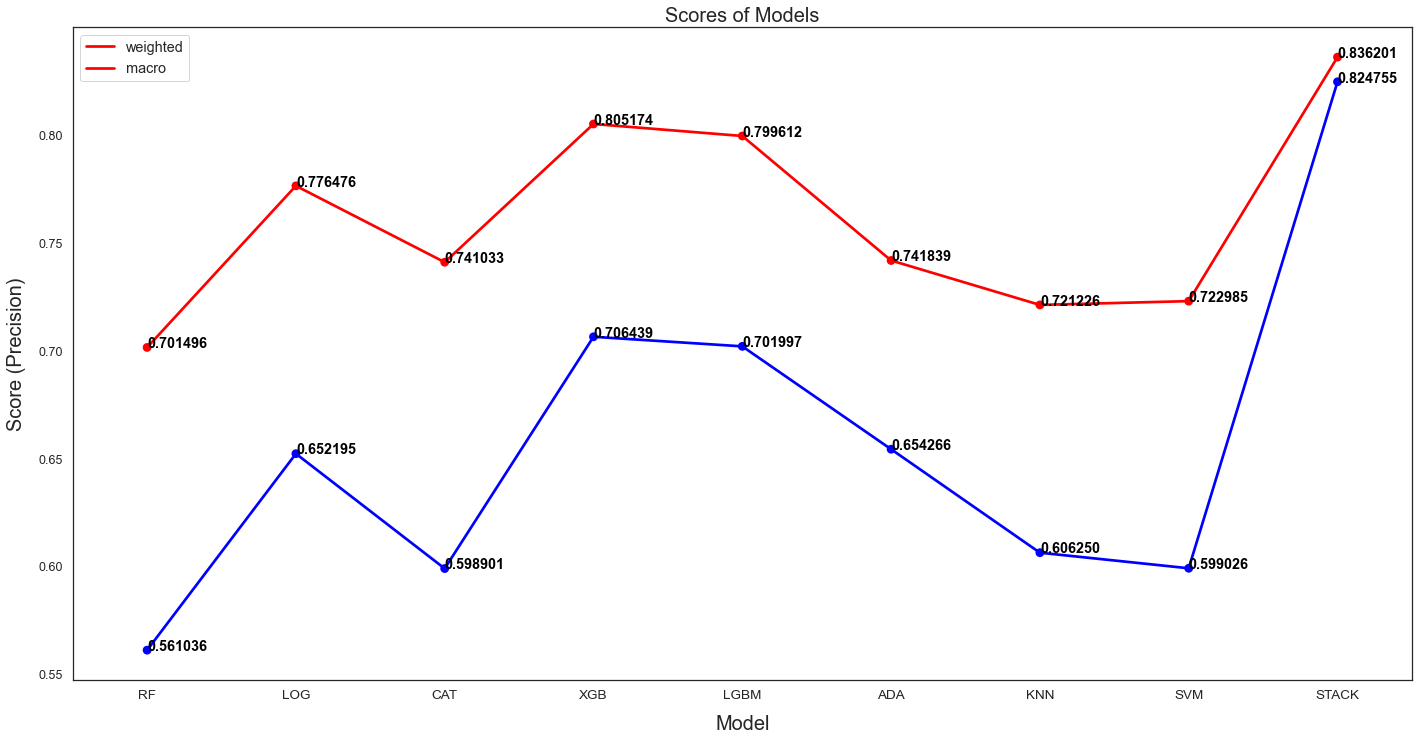

In [236]:
sns.set_style("white")
fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(scores_dic.keys()), y=[score for score, _ in scores_dic.values()],
                   markers=['o'],color='red', linestyles=['-'], label = 'weighted')
ax = sns.pointplot(x=list(scores_dic.keys()), y=[score for _, score in scores_dic.values()],
                   markers=['o'], color = 'blue', linestyles=['-'], label = 'macro')

for i, score in enumerate(scores_dic.values()):
    ax.text(i, score[0], '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')
for i, score in enumerate(scores_dic.values()):
    ax.text(i, score[1], '{:.6f}'.format(score[1]), horizontalalignment='left', size='large', color='black', weight='semibold')
    
plt.legend(labels = ['weighted','macro'], fontsize = 'large')


plt.ylabel('Score (Precision)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)


plt.title('Scores of Models', size=20)

plt.show()

In [92]:
conf = pd.DataFrame(confusion_matrix(y_test, y_pred_stack))

<AxesSubplot:>

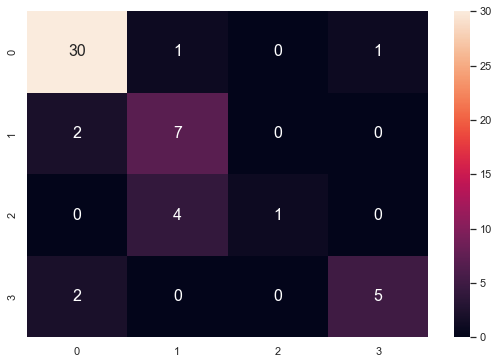

In [93]:
sns.heatmap(conf, annot=True,annot_kws={"size": 16})

In [419]:
final_pred = sclf.predict(all_fetures_red)

C:\Users\nbuser\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [317]:
probability = sclf.predict_proba(all_fetures_red)

C:\Users\nbuser\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [320]:
final_proba_df = pd.DataFrame(data=probability, columns=['type_1','type_4','type_6','type_7'])

In [321]:
final_proba_df.head()

,type_1,type_4,type_6,type_7
0,0.044154,0.805050,0.136098,0.014698
1,0.046897,0.791804,0.145410,0.015890
2,0.046928,0.791612,0.145543,0.015917
3,0.042233,0.815090,0.128934,0.013743
4,0.044496,0.803713,0.137016,0.014774


### Export

In [323]:
pz_types_map = xy_coord.join(final_pred_df).to_csv('pz_types_map.txt', sep = ' ')

In [324]:
pz_types_proba =  xy_coord.join(final_proba_df).to_csv('pz_types_proba.txt', sep = ' ')

<div class="alert alert-block alert-warning">
    <h2 align='center'>🚧WORK IN PROGRESS🚧</h2>

</div>

### Next steps:

* Feature importance
* Stacking tuning
* Labels engeneering